Six-Hump Camel synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.6 MB/s 
     |████████████████████████████████| 872 kB 49.6 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19878 sha256=81a6d6661782b6a67d8ab574032be2703bd70f60841ef8c6f21fb41885f8def4
  Stored in directory: /root/.cache/pip/wheels/77/da/06/166ba012a0d819a121e3f58372c668c804511875d04e16f383
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=fec2567e24adc6c0a2dfed3d8464db73d82c4b07a82714df40037e2cd222663f
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'SixHumpCamel':
    
    # True y bounds:
    operator = -1
    y_lb = -1.0316 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -3 
    ub_x1 = +3
    lb_x2 = -2 
    ub_x2 = +2

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
        

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = -1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        GP dEI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    
1  	 [-1.19209699 -0.31431616]	 2.418604194089478	 -0.2650082867644827	 1.5097990090803877
2  	 [-0.22547579  1.70883971]	 22.240849622618942	 -0.2650082867644827	 0.7046348253537699
3  	 [ 2.48246431 -1.70176508]	 40.65026890583644	 -0.2650082867644827	 0.6723744435129764
4  	 [3. 2.]	 162.89999999999998	 -0.2650082867644827	 0.6723360499298292
5  	 [-3.  2.]	 150.89999999999998	 -0.2650082867644827	 0.6683819182371965
6  	 [-0.58935416 -0.48427705]	 0.7172893452801496	 -0.2650082867644827	 1.7543231365727925
7  	 [-

In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1  	 [-0.39431495 -0.08552524]	 0.5771014397304058	 0.011939608840498828	 0.906568619126185
2  	 [ 1.85203999 -0.19665791]	 1.9520503538370169	 0.011939608840498828	 0.8038997384103904
3  	 [0.73875436 2.        ]	 51.08923695270019	 0.011939608840498828	 0.8038430929767131
4  	 [ 3. -2.]	 150.89999999999998	 0.011939608840498828	 0.8036905829278483
5  	 [-3.  2.]	 150.89999999999998	 0.011939608840498828	 0.8036394057940972
6  	 [-3. -2.]	 162.89999999999998	 0.011939608840498828	 0.803404592401801
7  	 [-0.9844

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    
1  	 [-0.2309166   0.29148206]	 -0.1709116466540207	 -0.2431922946563294	 0.9349098832252827
2	 [-0.39661823  0.8583581 ]	 -0.5376272709585427	 -0.5376272709585427	 0.7838215742349289
3  	 [-0.20567488  0.24083004]	 -0.10259756511713929	 -0.5376272709585427	 0.6200783228144964
4  	 [-0.53334406  1.38957064]	 7.4244290218126	 -0.5376272709585427	 0.6048661533028978
5  	 [ 0.02178157 -0.23983294]	 -0.22017189571021173	 -0.5376272709585427	 0.704778016502448
6  	 [-0.02409238 -0.13744117]	 -0.06850061181348849	 -0.53762727095

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    
1	 [ 0.13819595 -1.09159236]	 0.8378729983345513	 0.8378729983345513	 3.7916921413335207
2	 [ 0.16279961 -1.07402786]	 0.6381310288891437	 0.6381310288891437	 1.4908153932174946
3  	 [-3.  2.]	 150.89999999999998	 0.6381310288891437	 1.1409869665791987
4  	 [-3. -2.]	 162.89999999999998	 0.6381310288891437	 1.1311537715140516
5	 [-0.26848645 -0.13256574]	 0.24408538465589355	 0.24408538465589355	 1.4217620586582336
6	 [ 0.09461061 -0.68489841]	 -1.0253392627072793	 -1.0253392627072793	 0.9224907685939852
7  	 [ 0.06534235 -0.611

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    
1  	 [0.32583964 1.00818374]	 0.7967371894748262	 -0.6512780061070701	 0.523408070519103
2  	 [ 3. -2.]	 150.89999999999998	 -0.6512780061070701	 0.5131927061669258
3  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 0.508620246487194
4  	 [0.4254109 0.0313057]	 0.6664962659071133	 -0.6512780061070701	 0.4887484722236481
5  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 0.4234000297201961
6  	 [-0.00420925 -0.36483768]	 -0.4599501642496032	 -0.6512780061070701	 0.4013201649202892
7  	 [ 0.00399182 -0.33000859]	 -

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    
1  	 [0.19888424 0.91003727]	 -0.23327669759911474	 -0.3096187466378422	 0.7522208865862204
2	 [0.11616366 0.67403998]	 -0.8597635887265809	 -0.8597635887265809	 0.6621933034826909
3  	 [0.13061593 0.7053691 ]	 -0.8402109420699337	 -0.8597635887265809	 0.4609708623254385
4  	 [0.13127649 0.70691014]	 -0.8388869269372223	 -0.8597635887265809	 0.4803783256048187
5  	 [0.1317468  0.70800797]	 -0.8379177577819039	 -0.8597635887265809	 0.49301007810746145
6  	 [0.132092   0.70881635]	 -0.8371919685687033	 -0.8597635887265

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    
1  	 [0.14003009 1.65200772]	 19.18503288903285	 -0.46481072558790276	 0.6285586421843669
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 0.5869305043864016
3  	 [-0.47109136  0.58002622]	 -0.3783020334196958	 -0.46481072558790276	 0.6533643807880518
4	 [-0.14196887  0.42856901]	 -0.5808180226262771	 -0.5808180226262771	 0.620625425244183
5  	 [-0.3520866   0.51707111]	 -0.5013495032619739	 -0.5808180226262771	 0.5782423919830233
6  	 [-0.74791688  0.80059305]	 0.11945089884471094	 -0

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1  	 [-0.77086886  0.84272184]	 0.23242422233356008	 0.03190064766213015	 0.91523883411738
2  	 [-3.  2.]	 150.89999999999998	 0.03190064766213015	 0.8081807517734181
3	 [-0.24360329  0.39126551]	 -0.38387907993258125	 -0.38387907993258125	 0.9759772757460892
4  	 [-0.24416435  0.38712394]	 -0.3730716827364074	 -0.38387907993258125	 0.686632366675899
5  	 [-0.24497437  0.38151423]	 -0.3583721394862776	 -0.38387907993258125	 0.658142316348085
6  	 [-0.24548886  0.37772027]	 -0.3484894307524471	 -0.38387907993258125	 0.638679

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    
1  	 [0.19950386 1.29272168]	 4.899980086595864	 1.395407492769129	 1.6825554726423106
2  	 [ 3.         -0.21547441]	 108.07648258328325	 1.395407492769129	 1.6820245197700332
3  	 [-1.44939862  2.        ]	 47.32689265929798	 1.395407492769129	 1.5059197460104214
4  	 [-1.57484893 -2.        ]	 53.238148922947346	 1.395407492769129	 1.0433687877426328
5	 [-0.51196048 -0.15338005]	 0.8967863571366157	 0.8967863571366157	 1.6385935301672818
6  	 [1.95347264 2.        ]	 55.113868859122576	 0.8967863571366157	 1.2563661046213588
7	 [

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.242737374749332
2  	 [-3.  2.]	 150.89999999999998	 0.7775687473184012	 1.2003547477215273
3  	 [ 3.         -0.56605295]	 106.33084289570883	 0.7775687473184012	 1.2462221349744769
4	 [-0.7532562   0.62545309]	 0.23063111601765074	 0.23063111601765074	 4.702602429096982
5  	 [-0.77425408  0.62943664]	 0.270785017851114	 0.23063111601765074	 2.3621661132500993
6  	 [-0.78273918  0.63084953]	 0.28694075214717873	 0.23063111601765074	 1.7147653624616803
7  	 [-0.7870539   0

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    
1  	 [ 1.79052491 -2.        ]	 46.642439808247566	 -0.6254688257880329	 0.5012187568587065
2  	 [-0.41855111  2.        ]	 47.800981468687965	 -0.6254688257880329	 0.4990340161834902
3  	 [ 0.09051383 -0.00503656]	 0.03207290039322645	 -0.6254688257880329	 0.5878057730786099
4  	 [ 0.08003266 -0.00212966]	 0.025346253591978556	 -0.6254688257880329	 0.4792252975615052
5  	 [ 0.07460426 -0.00058538]	 0.022153143735240476	 -0.6254688257880329	 0.4301721959379141
6  	 [0.07129016 0.00037421]	 0.02030106785475776	 -0.6254688

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    
1	 [-1.337878    0.82388566]	 0.36879704199305774	 0.36879704199305774	 2.6078869720887123
2  	 [1.74301928 2.        ]	 53.60261104768335	 0.36879704199305774	 0.9958062237839763
3  	 [-3. -2.]	 162.89999999999998	 0.36879704199305774	 0.9956543245697344
4  	 [-0.16291724 -2.        ]	 48.430529410549696	 0.36879704199305774	 0.988297440269319
5	 [-1.49393438  0.64566136]	 0.23577047222883796	 0.23577047222883796	 0.9799676544724304
6  	 [-0.63881474  1.79548609]	 28.83398703617356	 0.23577047222883796	 0.8777436401718827
7

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    
1  	 [ 0.69815135 -1.5584218 ]	 14.280544136905649	 0.752930921147986	 2.68563201296615
2  	 [-3.  2.]	 150.89999999999998	 0.752930921147986	 1.2302321816711441
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 1.2302321776790974
4  	 [-1.32681869 -1.1815997 ]	 6.132474358637779	 0.752930921147986	 1.2302321819970747
5	 [-0.19817028  0.59883805]	 -0.8848366775560662	 -0.8848366775560662	 1.2251818292022054
6  	 [-0.23865393  0.58626093]	 -0.8211249819209709	 -0.8848366775560662	 0.4817856001294038
7  	 [-0.23022375  0.58730585]	 -0.8

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 0.3866284247694952
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 0.3866284247694952
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 0.3866284247694952
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 0.3866284247694952
5  	 [ 0.10283639 -0.51837162]	 -0.7972587881828173	 -1.029299726828387	 0.4828729102685634
6  	 [ 0.23768276 -0.55410632]	 -0.7634273267633378	 -1.029299726828387	 0.48

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    
1  	 [-0.31230925  1.23090386]	 3.107966059914712	 2.1163170846379233	 2.2682349603974403
2  	 [3. 2.]	 162.89999999999998	 2.1163170846379233	 2.2652732718226036
3  	 [-3.  2.]	 150.89999999999998	 2.1163170846379233	 2.2467674329839866
4	 [-0.27070757 -0.29550408]	 0.04318936470340434	 0.04318936470340434	 2.966959336757291
5  	 [-0.27822716 -0.29112708]	 0.06792524325045923	 0.04318936470340434	 0.9456885277761657
6  	 [-0.28998257 -0.28350518]	 0.10825994237381381	 0.04318936470340434	 0.8253726733400902
7  	 [-0.29693398

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    
1  	 [ 3.         -0.04378922]	 108.7609770576423	 1.8632773736203017	 2.053886212873812
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 2.047899482520367
3  	 [0.53255234 2.        ]	 50.03824175828417	 1.8632773736203017	 2.042164250384682
4  	 [-0.91745731 -0.01809519]	 2.093131287996447	 1.8632773736203017	 1.485430760028271
5  	 [-1.03036552 -0.06609219]	 2.329255444267561	 1.8632773736203017	 1.0117265666364919
6  	 [-1.07315926 -0.0768716 ]	 2.3895267258174884	 1.8632773736203017	 0.7980262281624964
7  	 [ 2.26

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    
1	 [-0.55712466  1.08599903]	 1.2904712864486778	 1.2904712864486778	 2.4395876955173423
2  	 [ 3. -2.]	 150.89999999999998	 1.2904712864486778	 1.5912883774316626
3  	 [3. 2.]	 162.89999999999998	 1.2904712864486778	 1.524132247295509
4  	 [0.92241907 0.18981443]	 2.1246079247590357	 1.2904712864486778	 1.4178588579102105
5  	 [-1.56013619  2.        ]	 46.98120007046126	 1.2904712864486778	 1.4242832287494782
6	 [-0.26160156  0.25122854]	 -0.038237284416990897	 -0.038237284416990897	 1.8708057096394757
7	 [-0.26130207  0.252599

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    
1  	 [-3.  2.]	 150.89999999999998	 2.062169771852028	 2.2168306774450874
2	 [ 0.51933718 -0.47021367]	 -0.0004387791505781058	 -0.0004387791505781058	 1.022904098881382
3	 [ 0.46722715 -0.47742819]	 -0.15039958734018488	 -0.15039958734018488	 0.33973799744242655
4	 [ 0.44976542 -0.47473192]	 -0.1858510183284554	 -0.1858510183284554	 0.36646653580790994
5	 [ 0.44009002 -0.47280303]	 -0.2039971659151858	 -0.2039971659151858	 0.3984728438108926
6	 [ 0.43358498 -0.47135969]	 -0.2156592800569721	 -0.2156592800569721	 0.42174939843016007
7	 [ 0

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    
1  	 [-0.04594902  2.        ]	 47.916537858903055	 6.578088852480828	 5.923965955295372
2  	 [ 1.6626862 -2.       ]	 46.725988988445636	 6.578088852480828	 6.421344447472726
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 4.553585229212489
4	 [-0.30754482 -0.24340017]	 0.21175163798172386	 0.21175163798172386	 3.328302393361501
5	 [-0.23874691 -0.2198156 ]	 0.08978273567635284	 0.08978273567635284	 0.1845406628499552
6	 [-0.21242247 -0.21285343]	 0.04844727516002503	 0.04844727516002503	 0.25375055167765936
7	 [-0.19619434 -

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    
1  	 [-1.16287628 -2.        ]	 52.71897154250457	 1.5037392797834441	 1.6228041681659169
2  	 [ 3. -2.]	 150.89999999999998	 1.5037392797834441	 1.6680546482650702
3	 [ 0.44491632 -0.32008893]	 0.2018495674177776	 0.2018495674177776	 0.7085212854773342
4  	 [ 0.44440557 -0.31347918]	 0.21688159575915594	 0.2018495674177776	 0.35438590133011955
5  	 [ 0.44473352 -0.31307705]	 0.21870336094154053	 0.2018495674177776	 0.405353986196912
6  	 [ 0.44492254 -0.3128241 ]	 0.21980544163944155	 0.2018495674177776	 0.4357663274357303
7  	 

In [33]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    
1  	 [-1.0222508  -0.56767233]	 1.9738149569435763	 -0.2650082867644827	 1.337802723187696
2  	 [-1.26808267 -0.11971967]	 2.4833208094638186	 -0.2650082867644827	 0.8119767266061961
3  	 [-0.4682545   1.65874906]	 19.278966809435275	 -0.2650082867644827	 0.7060383202615662
4  	 [0.57640459 0.14873338]	 1.108587133549329	 -0.2650082867644827	 0.6973396676340106
5  	 [3. 2.]	 162.89999999999998	 -0.2650082867644827	 0.6723624063265204
6  	 [ 1.62245446 -2.        ]	 46.81311522637849	 -0.2650082867644827	 0.67193039036

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    
1  	 [-0.31993922 -0.13822595]	 0.35705703278801193	 0.011939608840498828	 0.9015114982733211
2  	 [ 2.04712486 -0.34678071]	 3.2819773046713774	 0.011939608840498828	 0.8038736053985057
3  	 [0.87539145 2.        ]	 51.73283837601235	 0.011939608840498828	 0.803856887569106
4  	 [-3. -2.]	 162.89999999999998	 0.011939608840498828	 0.8034960174697786
5  	 [3.         1.37226805]	 119.66888349229755	 0.011939608840498828	 0.798047103561054
6  	 [-1.21016181  0.32572009]	 1.6274790665782064	 0.011939608840498828	 1

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    
1  	 [-0.24615031  0.33088407]	 -0.23671242014455512	 -0.2431922946563294	 0.9345839458281968
2	 [-0.26381503  0.4354689 ]	 -0.4612393470974674	 -0.4612393470974674	 0.7867737753492747
3  	 [-0.51799266  1.2341212 ]	 3.4758193603861836	 -0.4612393470974674	 0.6561897207749525
4  	 [-0.0673234  -0.21593135]	 -0.14518543952304563	 -0.4612393470974674	 0.7615632543494404
5  	 [ 0.05023894 -0.29319294]	 -0.31893773832699984	 -0.4612393470974674	 0.6346183053978937
6  	 [ 0.12147888 -0.35789422]	 -0.43163102803521386	 -0.461239

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    
1	 [-0.19248638 -0.29673967]	 -0.118746904624908	 -0.118746904624908	 2.801662033633455
2	 [ 0.0771446 -0.9683799]	 -0.2844404270558513	 -0.2844404270558513	 1.4618491526354545
3  	 [ 0.15454763 -1.42856043]	 8.369638169079648	 -0.2844404270558513	 1.0080760300974796
4  	 [-0.59840288  1.94539575]	 42.167704564580156	 -0.2844404270558513	 0.6339682859220072
5  	 [-3. -2.]	 162.89999999999998	 -0.2844404270558513	 0.6339729933996755
6	 [ 0.4344578  -0.88853037]	 -0.3683825364525794	 -0.3683825364525794	 0.1791702058990037
7	 [-0.

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    
1  	 [0.27873899 1.08341635]	 1.4162287546962613	 -0.6512780061070701	 0.5212081300221553
2  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 0.5110424854660709
3  	 [ 2.22867989 -2.        ]	 52.44856270446538	 -0.6512780061070701	 0.5135688175365126
4  	 [0.27494103 0.1639579 ]	 0.23095496884843886	 -0.6512780061070701	 0.4391275416005083
5  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 0.4220209811641843
6  	 [-0.19095792 -0.04204985]	 0.14405301455804922	 -0.6512780061070701	 0.4055430203552807
7  	 [ 0.2261

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    
1  	 [0.14564833 0.99656045]	 0.20177881687152865	 -0.3096187466378422	 0.7490117988921283
2  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 0.624361690543775
3	 [-0.20642557  0.73264737]	 -0.9791695830839107	 -0.9791695830839107	 0.5720634054283468
4  	 [-0.1567979   0.53674031]	 -0.8074587029374714	 -0.9791695830839107	 0.4034354809521641
5  	 [-0.08928664  0.26902626]	 -0.2608132060388308	 -0.9791695830839107	 0.4338798308610164
6  	 [-0.11041711  0.38382373]	 -0.4963936304845496	 -0.9791695830839107	 0.40046

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    
1  	 [0.1310842  1.64834684]	 18.945381193780257	 -0.46481072558790276	 0.6285322890609756
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 0.5869305043864016
3  	 [-0.62752856  0.70661994]	 -0.17355017380823146	 -0.46481072558790276	 0.6492442081456917
4	 [-0.29852921  0.52826691]	 -0.6224198225575582	 -0.6224198225575582	 0.6233739906842195
5  	 [-3. -2.]	 162.89999999999998	 -0.6224198225575582	 0.5250001495628585
6  	 [2.09924505 2.        ]	 57.57059352637283	 -0.6224198225575582	

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    
1	 [-0.57246742  0.6534526 ]	 -0.25569579328253045	 -0.25569579328253045	 0.9022574499586161
2  	 [-1.18831557  1.21804401]	 3.8222330710419667	 -0.25569579328253045	 0.6921018395852151
3  	 [0.04982841 0.04620172]	 0.003700531824410219	 -0.25569579328253045	 0.5314874765523403
4  	 [ 1.5233709  -1.90834873]	 37.71548823920068	 -0.25569579328253045	 0.5544341266061554
5	 [-0.33912575  0.43440778]	 -0.32695670284957334	 -0.32695670284957334	 0.568974023715323
6  	 [-0.0246738   0.15315498]	 -0.09296948437208957	 -0.326956702

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    
1  	 [0.30007956 2.        ]	 48.94356541468191	 1.395407492769129	 1.6822915469107884
2  	 [3.         0.35932676]	 109.528200874667	 1.395407492769129	 1.680932054459341
3  	 [ 1.74044958 -1.84128563]	 31.323868720181455	 1.395407492769129	 1.4217090234463703
4  	 [-1.55536773 -2.        ]	 53.216714029899045	 1.395407492769129	 1.1926782124922368
5	 [-0.45357128 -0.14814099]	 0.7182664624905546	 0.7182664624905546	 1.721912455123421
6  	 [-1.96004765  2.        ]	 47.35319532029028	 0.7182664624905546	 1.0437483543390875
7	 [-0.1

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.242737374749332
2  	 [-2.52977022  2.        ]	 69.90104466534116	 0.7775687473184012	 1.1534076357755347
3  	 [-0.96096779  0.29985852]	 1.5500307910683613	 0.7775687473184012	 1.2459534857113914
4  	 [ 3.         -0.28423181]	 107.75026028666434	 0.7775687473184012	 1.2461072221951357
5	 [-0.348341    0.78170365]	 -0.7679201385345631	 -0.7679201385345631	 1.8933802765586911
6	 [-0.31261101  0.73686067]	 -0.8518092149277464	 -0.8518092149277464	 0.7362749203953383
7  	 [

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    
1  	 [0.1162043  0.20936558]	 -0.08968928579150665	 -0.6254688257880329	 0.4979421281625386
2  	 [-0.26857992  1.50634431]	 11.391644241601337	 -0.6254688257880329	 0.46476682236841
3  	 [ 1.46188583 -1.88617587]	 35.8505521757125	 -0.6254688257880329	 0.49924493450018015
4  	 [ 0.19155584 -0.03220303]	 0.13365101792458087	 -0.6254688257880329	 0.1756330394634262
5  	 [0.05153275 0.10757978]	 -0.02960628402370909	 -0.6254688257880329	 0.2513158209681263
6  	 [-0.14985578  0.35002975]	 -0.39372013328167677	 -0.62546882578

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    
1	 [-1.15648604  0.74752304]	 0.5401694705946541	 0.5401694705946541	 2.435731761390791
2  	 [1.83110409 2.        ]	 54.030151566854705	 0.5401694705946541	 1.0968899682399211
3  	 [-3. -2.]	 162.89999999999998	 0.5401694705946541	 1.0967323724584053
4  	 [-0.1634226 -2.       ]	 48.432181477152	 0.5401694705946541	 1.08901945942379
5	 [-1.47701762  0.78295106]	 0.08738741316331844	 0.08738741316331844	 1.0876994167300023
6  	 [-0.56372555  1.77672487]	 27.301492466718933	 0.08738741316331844	 0.8000911634482369
7  	 [-1.32

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    
1  	 [ 0.4943127  -1.24330367]	 3.617106922875216	 0.752930921147986	 2.6187640905685425
2  	 [-0.83460691  1.3144168 ]	 5.811882953645614	 0.752930921147986	 1.598822105756367
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 1.2263652050001004
4  	 [ 1.11089436 -2.        ]	 48.14281330125023	 0.752930921147986	 1.320203587249645
5  	 [ 2.10322474 -1.94085306]	 43.06366123572329	 0.752930921147986	 1.2302321819970747
6	 [ 0.67539348 -0.4460929 ]	 0.48041758029772375	 0.48041758029772375	 1.1523340059871703
7	 [ 0.28034324 -0.0950155

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 0.3866284247694952
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 0.3866284247694952
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 0.3866284247694952
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 0.3866284247694952
5  	 [ 0.17242163 -0.54461366]	 -0.811353901266326	 -1.029299726828387	 0.48088520424647574
6  	 [ 0.06717019 -0.52421601]	 -0.8143512817292351	 -1.029299726828387	 0.48

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    
1	 [-0.21638275  1.08971893]	 0.837475442441042	 0.837475442441042	 2.2680470317080035
2  	 [3. 2.]	 162.89999999999998	 0.837475442441042	 1.285553155314791
3  	 [-1.96941567  2.        ]	 47.43342240539559	 0.837475442441042	 1.2719067300092128
4  	 [-0.17804804 -2.        ]	 48.4808006875014	 0.837475442441042	 1.2619425086575085
5  	 [0.70088083 0.45442263]	 1.1607617601927824	 0.837475442441042	 1.2077437565965479
6  	 [0.44051215 2.        ]	 49.58058670666018	 0.837475442441042	 1.1593784253114032
7	 [-0.33208872  0.14

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    
1  	 [ 3.         -0.03166106]	 108.80101115742967	 1.8632773736203017	 2.05388559765654
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 2.047894663117556
3  	 [0.53458945 2.        ]	 50.04858828808778	 1.8632773736203017	 2.041814102376638
4  	 [-1.10134941  0.07301427]	 2.25541265535764	 1.8632773736203017	 1.4047282842161761
5	 [-0.38436994 -0.07390268]	 0.5528776934672587	 0.5528776934672587	 0.876407034278634
6  	 [-0.42109164 -0.02890779]	 0.6539364235501978	 0.5528776934672587	 0.43919736010253724
7  	 [-0.674

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    
1  	 [-0.94844345  1.77369891]	 27.464707626764916	 1.7722768782964888	 2.250920008342742
2  	 [ 2.16747806 -2.        ]	 50.670774669928775	 1.7722768782964888	 1.9472789324332946
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 1.87718084296977
4  	 [0.97958062 0.2221369 ]	 2.229137979813862	 1.7722768782964888	 1.6277903229034736
5	 [-0.08334248 -0.32165678]	 -0.3165435517895191	 -0.3165435517895191	 1.264151086728202
6	 [-0.00456981 -0.44315296]	 -0.6291619745773486	 -0.6291619745773486	 0.37588789597480077
7  	 [-0.1632

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    
1  	 [-2.66531515  1.40819569]	 45.982813537937645	 2.062169771852028	 2.19985588075394
2  	 [3.        0.6031628]	 109.78368431836117	 2.062169771852028	 0.9295860323761012
3  	 [1.89592609 0.6375228 ]	 2.969704029748832	 2.062169771852028	 2.2191685332046376
4  	 [-0.32173714 -1.49268739]	 11.817714263649087	 2.062169771852028	 2.2191685332046376
5	 [-0.73927187  0.43212922]	 0.686338663645771	 0.686338663645771	 2.210140934062737
6  	 [-3.         -0.66721437]	 109.91366621956408	 0.686338663645771	 1.1776017029393353
7	 [-0.30694961 -0

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    
1  	 [0.10116931 2.        ]	 48.243059900228204	 6.578088852480828	 5.89231557551927
2  	 [ 1.4154914  -1.88944898]	 36.29074861563762	 6.578088852480828	 6.479937231371906
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 4.56582528616582
4	 [-0.2606682 -0.1399839]	 0.22184398731126448	 0.22184398731126448	 3.796201174453703
5	 [ 0.19813133 -0.17803827]	 -0.004238427612070855	 -0.004238427612070855	 0.19128409868887702
6  	 [-0.27430555 -0.08600945]	 0.2834480626298939	 -0.004238427612070855	 0.2876168780218436
7	 [ 0.15377079

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    
1  	 [-1.18115566 -2.        ]	 52.76057163057528	 1.5037392797834441	 1.6226897877682127
2  	 [ 2.59213852 -1.65326133]	 47.84960809826183	 1.5037392797834441	 1.4750079879150166
3	 [ 0.22139217 -0.162917  ]	 0.05163369461120049	 0.05163369461120049	 0.4690237988202402
4	 [-0.33967677  0.28979802]	 0.02792003913677127	 0.02792003913677127	 0.09328850938049889
5	 [ 0.04615981 -0.02633349]	 0.004525945620337681	 0.004525945620337681	 0.32577558211904684
6	 [-0.51229094  0.50493252]	 -0.10733364280664648	 -0.10733364280664648	 0.07

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.2658009358573259, -0.2658009358573259)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.03335866621503685, -0.09141497463908152)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-0.7052749676875513, -1.5614956503396664)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-5.073457322415554, -1.5236556203622285)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-1.8466634597692166, -2.4166011145214363)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-1.7612123519962217, -2.948268380567984)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-0.7967714768221764, -0.8935996883007996)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-0.4342953543069644, -1.6667913180754064)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-0.03500236543565779, -2.308064508535467)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(0.23288088207270655, -1.715961409246572)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.9010790823704407, -1.114233240672264)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(0.23694425972585687, 0.11242418097637234)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-1.9189340411308784, -3.098925676781255)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-6.074727392833108, -6.074727392833108)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(0.07212470257012685, 0.04583613435076517)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(1.039479277229328, 0.021252512399301267)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-0.055523946348320315, -3.7104768208036245)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(-0.25645327829802333, -0.5314644193063522)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-0.02299266239598735, -0.02543456866139696)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(0.2098147703936484, -0.0787549835201568)

In [73]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [76]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [77]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [78]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [79]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [80]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [81]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [82]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [83]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [86]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [87]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [88]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [89]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [90]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [91]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [92]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [93]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [94]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [95]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [96]:
def acqFuncExtract(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-2]
    return new_array


In [97]:
simple_regret_approx_1_acqFuncMin = acqFuncExtract(approx_1.history)
simple_regret_approx_2_acqFuncMin = acqFuncExtract(approx_2.history)
simple_regret_approx_3_acqFuncMin = acqFuncExtract(approx_3.history)
simple_regret_approx_4_acqFuncMin = acqFuncExtract(approx_4.history)
simple_regret_approx_5_acqFuncMin = acqFuncExtract(approx_5.history)
simple_regret_approx_6_acqFuncMin = acqFuncExtract(approx_6.history)
simple_regret_approx_7_acqFuncMin = acqFuncExtract(approx_7.history)
simple_regret_approx_8_acqFuncMin = acqFuncExtract(approx_8.history)
simple_regret_approx_9_acqFuncMin = acqFuncExtract(approx_9.history)
simple_regret_approx_10_acqFuncMin = acqFuncExtract(approx_10.history)
simple_regret_approx_11_acqFuncMin = acqFuncExtract(approx_11.history)
simple_regret_approx_12_acqFuncMin = acqFuncExtract(approx_12.history)
simple_regret_approx_13_acqFuncMin = acqFuncExtract(approx_13.history)
simple_regret_approx_14_acqFuncMin = acqFuncExtract(approx_14.history)
simple_regret_approx_15_acqFuncMin = acqFuncExtract(approx_15.history)
simple_regret_approx_16_acqFuncMin = acqFuncExtract(approx_16.history)
simple_regret_approx_17_acqFuncMin = acqFuncExtract(approx_17.history)
simple_regret_approx_18_acqFuncMin = acqFuncExtract(approx_18.history)
simple_regret_approx_19_acqFuncMin = acqFuncExtract(approx_19.history)
simple_regret_approx_20_acqFuncMin = acqFuncExtract(approx_20.history)


In [98]:
simple_regret_exact_1_acqFuncMin = acqFuncExtract(exact_1.history)
simple_regret_exact_2_acqFuncMin = acqFuncExtract(exact_2.history)
simple_regret_exact_3_acqFuncMin = acqFuncExtract(exact_3.history)
simple_regret_exact_4_acqFuncMin = acqFuncExtract(exact_4.history)
simple_regret_exact_5_acqFuncMin = acqFuncExtract(exact_5.history)
simple_regret_exact_6_acqFuncMin = acqFuncExtract(exact_6.history)
simple_regret_exact_7_acqFuncMin = acqFuncExtract(exact_7.history)
simple_regret_exact_8_acqFuncMin = acqFuncExtract(exact_8.history)
simple_regret_exact_9_acqFuncMin = acqFuncExtract(exact_9.history)
simple_regret_exact_10_acqFuncMin = acqFuncExtract(exact_10.history)
simple_regret_exact_11_acqFuncMin = acqFuncExtract(exact_11.history)
simple_regret_exact_12_acqFuncMin = acqFuncExtract(exact_12.history)
simple_regret_exact_13_acqFuncMin = acqFuncExtract(exact_13.history)
simple_regret_exact_14_acqFuncMin = acqFuncExtract(exact_14.history)
simple_regret_exact_15_acqFuncMin = acqFuncExtract(exact_15.history)
simple_regret_exact_16_acqFuncMin = acqFuncExtract(exact_16.history)
simple_regret_exact_17_acqFuncMin = acqFuncExtract(exact_17.history)
simple_regret_exact_18_acqFuncMin = acqFuncExtract(exact_18.history)
simple_regret_exact_19_acqFuncMin = acqFuncExtract(exact_19.history)
simple_regret_exact_20_acqFuncMin = acqFuncExtract(exact_20.history)


In [99]:
### Simple regret minimisation - acquisition function: run number = 1

bestAcqFunc = 0

regret_approx_1_acqFuncMin = np.log(simple_regret_approx_1_acqFuncMin - bestAcqFunc + eps)
regret_exact_1_acqFuncMin = np.log(simple_regret_exact_1_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_1_acqFuncMin = min_max_array(regret_approx_1_acqFuncMin)
simple_regret_exact_1_acqFuncMin = min_max_array(regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin = min(simple_regret_approx_1_acqFuncMin)
min_simple_regret_exact_1_acqFuncMin = min(simple_regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin, min_simple_regret_exact_1_acqFuncMin


(-1.6105368753022298, -1.3171956801684637)

In [100]:
### Simple regret minimisation - acquisition function: run number = 2

regret_approx_2_acqFuncMin = np.log(simple_regret_approx_2_acqFuncMin - bestAcqFunc + eps)
regret_exact_2_acqFuncMin = np.log(simple_regret_exact_2_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_2_acqFuncMin = min_max_array(regret_approx_2_acqFuncMin)
simple_regret_exact_2_acqFuncMin = min_max_array(regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin = min(simple_regret_approx_2_acqFuncMin)
min_simple_regret_exact_2_acqFuncMin = min(simple_regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin, min_simple_regret_exact_2_acqFuncMin


(-1.4557683350043602, -1.573051370522823)

In [101]:
### Simple regret minimisation - acquisition function: run number = 3

regret_approx_3_acqFuncMin = np.log(simple_regret_approx_3_acqFuncMin - bestAcqFunc + eps)
regret_exact_3_acqFuncMin = np.log(simple_regret_exact_3_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_3_acqFuncMin = min_max_array(regret_approx_3_acqFuncMin)
simple_regret_exact_3_acqFuncMin = min_max_array(regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin = min(simple_regret_approx_3_acqFuncMin)
min_simple_regret_exact_3_acqFuncMin = min(simple_regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin, min_simple_regret_exact_3_acqFuncMin


(-0.6992271609031873, -1.0179093580255623)

In [102]:
### Simple regret minimisation - acquisition function: run number = 4

regret_approx_4_acqFuncMin = np.log(simple_regret_approx_4_acqFuncMin - bestAcqFunc + eps)
regret_exact_4_acqFuncMin = np.log(simple_regret_exact_4_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_4_acqFuncMin = min_max_array(regret_approx_4_acqFuncMin)
simple_regret_exact_4_acqFuncMin = min_max_array(regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin = min(simple_regret_approx_4_acqFuncMin)
min_simple_regret_exact_4_acqFuncMin = min(simple_regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin, min_simple_regret_exact_4_acqFuncMin


(-0.9788247765362915, -2.3620388834434993)

In [103]:
### Simple regret minimisation - acquisition function: run number = 5

regret_approx_5_acqFuncMin = np.log(simple_regret_approx_5_acqFuncMin - bestAcqFunc + eps)
regret_exact_5_acqFuncMin = np.log(simple_regret_exact_5_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_5_acqFuncMin = min_max_array(regret_approx_5_acqFuncMin)
simple_regret_exact_5_acqFuncMin = min_max_array(regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin = min(simple_regret_approx_5_acqFuncMin)
min_simple_regret_exact_5_acqFuncMin = min(simple_regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin, min_simple_regret_exact_5_acqFuncMin


(-1.1293079869163665, -1.2028374635956138)

In [104]:
### Simple regret minimisation - acquisition function: run number = 6

regret_approx_6_acqFuncMin = np.log(simple_regret_approx_6_acqFuncMin - bestAcqFunc + eps)
regret_exact_6_acqFuncMin = np.log(simple_regret_exact_6_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_6_acqFuncMin = min_max_array(regret_approx_6_acqFuncMin)
simple_regret_exact_6_acqFuncMin = min_max_array(regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin = min(simple_regret_approx_6_acqFuncMin)
min_simple_regret_exact_6_acqFuncMin = min(simple_regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin, min_simple_regret_exact_6_acqFuncMin


(-0.7744204216574995, -1.8902161641262314)

In [105]:
### Simple regret minimisation - acquisition function: run number = 7

regret_approx_7_acqFuncMin = np.log(simple_regret_approx_7_acqFuncMin - bestAcqFunc + eps)
regret_exact_7_acqFuncMin = np.log(simple_regret_exact_7_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_7_acqFuncMin = min_max_array(regret_approx_7_acqFuncMin)
simple_regret_exact_7_acqFuncMin = min_max_array(regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin = min(simple_regret_approx_7_acqFuncMin)
min_simple_regret_exact_7_acqFuncMin = min(simple_regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin, min_simple_regret_exact_7_acqFuncMin


(-1.2205567064217893, -3.245651756437447)

In [106]:
### Simple regret minimisation - acquisition function: run number = 8

regret_approx_8_acqFuncMin = np.log(simple_regret_approx_8_acqFuncMin - bestAcqFunc + eps)
regret_exact_8_acqFuncMin = np.log(simple_regret_exact_8_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_8_acqFuncMin = min_max_array(regret_approx_8_acqFuncMin)
simple_regret_exact_8_acqFuncMin = min_max_array(regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin = min(simple_regret_approx_8_acqFuncMin)
min_simple_regret_exact_8_acqFuncMin = min(simple_regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin, min_simple_regret_exact_8_acqFuncMin


(-0.5734684070986754, -0.9174954575378057)

In [107]:
### Simple regret minimisation - acquisition function: run number = 9

regret_approx_9_acqFuncMin = np.log(simple_regret_approx_9_acqFuncMin - bestAcqFunc + eps)
regret_exact_9_acqFuncMin = np.log(simple_regret_exact_9_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_9_acqFuncMin = min_max_array(regret_approx_9_acqFuncMin)
simple_regret_exact_9_acqFuncMin = min_max_array(regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin = min(simple_regret_approx_9_acqFuncMin)
min_simple_regret_exact_9_acqFuncMin = min(simple_regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin, min_simple_regret_exact_9_acqFuncMin


(-0.6341980357563178, -5.923474463420567)

In [108]:
### Simple regret minimisation - acquisition function: run number = 10

regret_approx_10_acqFuncMin = np.log(simple_regret_approx_10_acqFuncMin - bestAcqFunc + eps)
regret_exact_10_acqFuncMin = np.log(simple_regret_exact_10_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_10_acqFuncMin = min_max_array(regret_approx_10_acqFuncMin)
simple_regret_exact_10_acqFuncMin = min_max_array(regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin = min(simple_regret_approx_10_acqFuncMin)
min_simple_regret_exact_10_acqFuncMin = min(simple_regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin, min_simple_regret_exact_10_acqFuncMin


(-0.3463348804419815, -2.1518249526151956)

In [109]:
### Simple regret minimisation - acquisition function: run number = 11

regret_approx_11_acqFuncMin = np.log(simple_regret_approx_11_acqFuncMin - bestAcqFunc + eps)
regret_exact_11_acqFuncMin = np.log(simple_regret_exact_11_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_11_acqFuncMin = min_max_array(regret_approx_11_acqFuncMin)
simple_regret_exact_11_acqFuncMin = min_max_array(regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin = min(simple_regret_approx_11_acqFuncMin)
min_simple_regret_exact_11_acqFuncMin = min(simple_regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin, min_simple_regret_exact_11_acqFuncMin


(-1.120704035522828, -2.9583097710454336)

In [110]:
### Simple regret minimisation - acquisition function: run number = 12

regret_approx_12_acqFuncMin = np.log(simple_regret_approx_12_acqFuncMin - bestAcqFunc + eps)
regret_exact_12_acqFuncMin = np.log(simple_regret_exact_12_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_12_acqFuncMin = min_max_array(regret_approx_12_acqFuncMin)
simple_regret_exact_12_acqFuncMin = min_max_array(regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin = min(simple_regret_approx_12_acqFuncMin)
min_simple_regret_exact_12_acqFuncMin = min(simple_regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin, min_simple_regret_exact_12_acqFuncMin


(-1.6821493627113289, -7.087107108333201)

In [111]:
### Simple regret minimisation - acquisition function: run number = 13

regret_approx_13_acqFuncMin = np.log(simple_regret_approx_13_acqFuncMin - bestAcqFunc + eps)
regret_exact_13_acqFuncMin = np.log(simple_regret_exact_13_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_13_acqFuncMin = min_max_array(regret_approx_13_acqFuncMin)
simple_regret_exact_13_acqFuncMin = min_max_array(regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin = min(simple_regret_approx_13_acqFuncMin)
min_simple_regret_exact_13_acqFuncMin = min(simple_regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin, min_simple_regret_exact_13_acqFuncMin


(-0.7302560561436053, -1.80551189663837)

In [112]:
### Simple regret minimisation - acquisition function: run number = 14

regret_approx_14_acqFuncMin = np.log(simple_regret_approx_14_acqFuncMin - bestAcqFunc + eps)
regret_exact_14_acqFuncMin = np.log(simple_regret_exact_14_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_14_acqFuncMin = min_max_array(regret_approx_14_acqFuncMin)
simple_regret_exact_14_acqFuncMin = min_max_array(regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin = min(simple_regret_approx_14_acqFuncMin)
min_simple_regret_exact_14_acqFuncMin = min(simple_regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin, min_simple_regret_exact_14_acqFuncMin


(-0.9502911640344834, -0.9502911640344834)

In [113]:
### Simple regret minimisation - acquisition function: run number = 15

regret_approx_15_acqFuncMin = np.log(simple_regret_approx_15_acqFuncMin - bestAcqFunc + eps)
regret_exact_15_acqFuncMin = np.log(simple_regret_exact_15_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_15_acqFuncMin = min_max_array(regret_approx_15_acqFuncMin)
simple_regret_exact_15_acqFuncMin = min_max_array(regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin = min(simple_regret_approx_15_acqFuncMin)
min_simple_regret_exact_15_acqFuncMin = min(simple_regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin, min_simple_regret_exact_15_acqFuncMin

regret_approx_15_acqFuncMin, regret_exact_15_acqFuncMin

(array([ 0.81900198,  0.81769541,  0.80949249,  1.08753764, -0.05584201,
        -0.19192026, -0.27927249, -0.30063916,  0.48298217,  0.28829879,
         0.14677231,  0.03823986, -0.04809541, -0.11865042, -0.17752289,
        -0.22747191, -0.27043287, -0.30780851, -0.3406431 , -0.36973174]),
 array([ 0.81891913,  0.2511891 ,  0.24051714,  0.23265222,  0.18875396,
         0.14788403,  0.82163068,  0.14132277, -0.22148647, -0.26408733,
        -0.36098756, -0.31285003, -0.93437935, -0.38263084, -0.43508389,
        -0.51185331, -0.75297715, -0.63363403, -0.53061894, -0.56386339]))

In [114]:
### Simple regret minimisation - acquisition function: run number = 16

regret_approx_16_acqFuncMin = np.log(simple_regret_approx_16_acqFuncMin - bestAcqFunc + eps)
regret_exact_16_acqFuncMin = np.log(simple_regret_exact_16_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_16_acqFuncMin = min_max_array(regret_approx_16_acqFuncMin)
simple_regret_exact_16_acqFuncMin = min_max_array(regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin = min(simple_regret_approx_16_acqFuncMin)
min_simple_regret_exact_16_acqFuncMin = min(simple_regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin, min_simple_regret_exact_16_acqFuncMin


(-0.5396039166940994, -1.079753845410317)

In [115]:
### Simple regret minimisation - acquisition function: run number = 17

regret_approx_17_acqFuncMin = np.log(simple_regret_approx_17_acqFuncMin - bestAcqFunc + eps)
regret_exact_17_acqFuncMin = np.log(simple_regret_exact_17_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_17_acqFuncMin = min_max_array(regret_approx_17_acqFuncMin)
simple_regret_exact_17_acqFuncMin = min_max_array(regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin = min(simple_regret_approx_17_acqFuncMin)
min_simple_regret_exact_17_acqFuncMin = min(simple_regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin, min_simple_regret_exact_17_acqFuncMin


(-0.5226248245435144, -1.7636772548906698)

In [116]:
### Simple regret minimisation - acquisition function: run number = 18

regret_approx_18_acqFuncMin = np.log(simple_regret_approx_18_acqFuncMin - bestAcqFunc + eps)
regret_exact_18_acqFuncMin = np.log(simple_regret_exact_18_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_18_acqFuncMin = min_max_array(regret_approx_18_acqFuncMin)
simple_regret_exact_18_acqFuncMin = min_max_array(regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin = min(simple_regret_approx_18_acqFuncMin)
min_simple_regret_exact_18_acqFuncMin = min(simple_regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin, min_simple_regret_exact_18_acqFuncMin


(-1.0795805247565828, -0.7439910177277349)

In [117]:
### Simple regret minimisation - acquisition function: run number = 19

regret_approx_19_acqFuncMin = np.log(simple_regret_approx_19_acqFuncMin - bestAcqFunc + eps)
regret_exact_19_acqFuncMin = np.log(simple_regret_exact_19_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_19_acqFuncMin = min_max_array(regret_approx_19_acqFuncMin)
simple_regret_exact_19_acqFuncMin = min_max_array(regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin = min(simple_regret_approx_19_acqFuncMin)
min_simple_regret_exact_19_acqFuncMin = min(simple_regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin, min_simple_regret_exact_19_acqFuncMin


(-1.689885390745629, -1.6539954760916329)

In [118]:
### Simple regret minimisation - acquisition function: run number = 20

regret_approx_20_acqFuncMin = np.log(simple_regret_approx_20_acqFuncMin - bestAcqFunc + eps)
regret_exact_20_acqFuncMin = np.log(simple_regret_exact_20_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_20_acqFuncMin = min_max_array(regret_approx_20_acqFuncMin)
simple_regret_exact_20_acqFuncMin = min_max_array(regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin = min(simple_regret_approx_20_acqFuncMin)
min_simple_regret_exact_20_acqFuncMin = min(simple_regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin, min_simple_regret_exact_20_acqFuncMin


(-1.0373688146245899, -4.304944659798804)

In [119]:
# Iteration1 :

slice1 = 0

modelFirst_1_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice1],
       simple_regret_approx_2_acqFuncMin[slice1],
       simple_regret_approx_3_acqFuncMin[slice1],
       simple_regret_approx_4_acqFuncMin[slice1],
       simple_regret_approx_5_acqFuncMin[slice1],
       simple_regret_approx_6_acqFuncMin[slice1],
       simple_regret_approx_7_acqFuncMin[slice1],
       simple_regret_approx_8_acqFuncMin[slice1],
       simple_regret_approx_9_acqFuncMin[slice1],
       simple_regret_approx_10_acqFuncMin[slice1],
       simple_regret_approx_11_acqFuncMin[slice1],
       simple_regret_approx_12_acqFuncMin[slice1],
       simple_regret_approx_13_acqFuncMin[slice1],
       simple_regret_approx_14_acqFuncMin[slice1],
       simple_regret_approx_15_acqFuncMin[slice1],
       simple_regret_approx_16_acqFuncMin[slice1],
       simple_regret_approx_17_acqFuncMin[slice1],
       simple_regret_approx_18_acqFuncMin[slice1],
       simple_regret_approx_19_acqFuncMin[slice1],
       simple_regret_approx_20_acqFuncMin[slice1]]

modelSecond_1_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice1],
       simple_regret_exact_2_acqFuncMin[slice1],
       simple_regret_exact_3_acqFuncMin[slice1],
       simple_regret_exact_4_acqFuncMin[slice1],
       simple_regret_exact_5_acqFuncMin[slice1],
       simple_regret_exact_6_acqFuncMin[slice1],
       simple_regret_exact_7_acqFuncMin[slice1],
       simple_regret_exact_8_acqFuncMin[slice1],
       simple_regret_exact_9_acqFuncMin[slice1],
       simple_regret_exact_10_acqFuncMin[slice1],
       simple_regret_exact_11_acqFuncMin[slice1],
       simple_regret_exact_12_acqFuncMin[slice1],
       simple_regret_exact_13_acqFuncMin[slice1],
       simple_regret_exact_14_acqFuncMin[slice1],
       simple_regret_exact_15_acqFuncMin[slice1],
       simple_regret_exact_16_acqFuncMin[slice1],
       simple_regret_exact_17_acqFuncMin[slice1],
       simple_regret_exact_18_acqFuncMin[slice1],
       simple_regret_exact_19_acqFuncMin[slice1],
       simple_regret_exact_20_acqFuncMin[slice1]]

modelFirst_1_results_acqFuncMin = pd.DataFrame(modelFirst_1_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_1_results_acqFuncMin = pd.DataFrame(modelSecond_1_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[4:5][0])[0]
median_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[9:10][0])[0]
upper_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[14:15][0])[0]

lower_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[4:5][0])[0]
median_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[9:10][0])[0]
upper_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[14:15][0])[0]


In [120]:
# Iteration11 :

slice11 = 10

modelFirst_11_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice11],
       simple_regret_approx_2_acqFuncMin[slice11],
       simple_regret_approx_3_acqFuncMin[slice11],
       simple_regret_approx_4_acqFuncMin[slice11],
       simple_regret_approx_5_acqFuncMin[slice11],
       simple_regret_approx_6_acqFuncMin[slice11],
       simple_regret_approx_7_acqFuncMin[slice11],
       simple_regret_approx_8_acqFuncMin[slice11],
       simple_regret_approx_9_acqFuncMin[slice11],
       simple_regret_approx_10_acqFuncMin[slice11],
       simple_regret_approx_11_acqFuncMin[slice11],
       simple_regret_approx_12_acqFuncMin[slice11],
       simple_regret_approx_13_acqFuncMin[slice11],
       simple_regret_approx_14_acqFuncMin[slice11],
       simple_regret_approx_15_acqFuncMin[slice11],
       simple_regret_approx_16_acqFuncMin[slice11],
       simple_regret_approx_17_acqFuncMin[slice11],
       simple_regret_approx_18_acqFuncMin[slice11],
       simple_regret_approx_19_acqFuncMin[slice11],
       simple_regret_approx_20_acqFuncMin[slice11]]

modelSecond_11_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice11],
       simple_regret_exact_2_acqFuncMin[slice11],
       simple_regret_exact_3_acqFuncMin[slice11],
       simple_regret_exact_4_acqFuncMin[slice11],
       simple_regret_exact_5_acqFuncMin[slice11],
       simple_regret_exact_6_acqFuncMin[slice11],
       simple_regret_exact_7_acqFuncMin[slice11],
       simple_regret_exact_8_acqFuncMin[slice11],
       simple_regret_exact_9_acqFuncMin[slice11],
       simple_regret_exact_10_acqFuncMin[slice11],
       simple_regret_exact_11_acqFuncMin[slice11],
       simple_regret_exact_12_acqFuncMin[slice11],
       simple_regret_exact_13_acqFuncMin[slice11],
       simple_regret_exact_14_acqFuncMin[slice11],
       simple_regret_exact_15_acqFuncMin[slice11],
       simple_regret_exact_16_acqFuncMin[slice11],
       simple_regret_exact_17_acqFuncMin[slice11],
       simple_regret_exact_18_acqFuncMin[slice11],
       simple_regret_exact_19_acqFuncMin[slice11],
       simple_regret_exact_20_acqFuncMin[slice11]]

modelFirst_11_acqFuncMin_results = pd.DataFrame(modelFirst_11_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_11_acqFuncMin_results = pd.DataFrame(modelSecond_11_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[4:5][0])[0]
median_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[9:10][0])[0]
upper_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[14:15][0])[0]

lower_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[4:5][0])[0]
median_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[9:10][0])[0]
upper_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[14:15][0])[0]


In [121]:
# Iteration2 :

slice2 = 1

modelFirst_2_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice2],
       simple_regret_approx_2_acqFuncMin[slice2],
       simple_regret_approx_3_acqFuncMin[slice2],
       simple_regret_approx_4_acqFuncMin[slice2],
       simple_regret_approx_5_acqFuncMin[slice2],
       simple_regret_approx_6_acqFuncMin[slice2],
       simple_regret_approx_7_acqFuncMin[slice2],
       simple_regret_approx_8_acqFuncMin[slice2],
       simple_regret_approx_9_acqFuncMin[slice2],
       simple_regret_approx_10_acqFuncMin[slice2],
       simple_regret_approx_11_acqFuncMin[slice2],
       simple_regret_approx_12_acqFuncMin[slice2],
       simple_regret_approx_13_acqFuncMin[slice2],
       simple_regret_approx_14_acqFuncMin[slice2],
       simple_regret_approx_15_acqFuncMin[slice2],
       simple_regret_approx_16_acqFuncMin[slice2],
       simple_regret_approx_17_acqFuncMin[slice2],
       simple_regret_approx_18_acqFuncMin[slice2],
       simple_regret_approx_19_acqFuncMin[slice2],
       simple_regret_approx_20_acqFuncMin[slice2]]

modelSecond_2_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice2],
       simple_regret_exact_2_acqFuncMin[slice2],
       simple_regret_exact_3_acqFuncMin[slice2],
       simple_regret_exact_4_acqFuncMin[slice2],
       simple_regret_exact_5_acqFuncMin[slice2],
       simple_regret_exact_6_acqFuncMin[slice2],
       simple_regret_exact_7_acqFuncMin[slice2],
       simple_regret_exact_8_acqFuncMin[slice2],
       simple_regret_exact_9_acqFuncMin[slice2],
       simple_regret_exact_10_acqFuncMin[slice2],
       simple_regret_exact_11_acqFuncMin[slice2],
       simple_regret_exact_12_acqFuncMin[slice2],
       simple_regret_exact_13_acqFuncMin[slice2],
       simple_regret_exact_14_acqFuncMin[slice2],
       simple_regret_exact_15_acqFuncMin[slice2],
       simple_regret_exact_16_acqFuncMin[slice2],
       simple_regret_exact_17_acqFuncMin[slice2],
       simple_regret_exact_18_acqFuncMin[slice2],
       simple_regret_exact_19_acqFuncMin[slice2],
       simple_regret_exact_20_acqFuncMin[slice2]]

modelFirst_2_results_acqFuncMin = pd.DataFrame(modelFirst_2_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_2_results_acqFuncMin = pd.DataFrame(modelSecond_2_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[4:5][0])[0]
median_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[9:10][0])[0]
upper_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[14:15][0])[0]

lower_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[4:5][0])[0]
median_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[9:10][0])[0]
upper_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[14:15][0])[0]


In [122]:
# Iteration12 :

slice12 = 11

modelFirst_12_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice12],
       simple_regret_approx_2_acqFuncMin[slice12],
       simple_regret_approx_3_acqFuncMin[slice12],
       simple_regret_approx_4_acqFuncMin[slice12],
       simple_regret_approx_5_acqFuncMin[slice12],
       simple_regret_approx_6_acqFuncMin[slice12],
       simple_regret_approx_7_acqFuncMin[slice12],
       simple_regret_approx_8_acqFuncMin[slice12],
       simple_regret_approx_9_acqFuncMin[slice12],
       simple_regret_approx_10_acqFuncMin[slice12],
       simple_regret_approx_11_acqFuncMin[slice12],
       simple_regret_approx_12_acqFuncMin[slice12],
       simple_regret_approx_13_acqFuncMin[slice12],
       simple_regret_approx_14_acqFuncMin[slice12],
       simple_regret_approx_15_acqFuncMin[slice12],
       simple_regret_approx_16_acqFuncMin[slice12],
       simple_regret_approx_17_acqFuncMin[slice12],
       simple_regret_approx_18_acqFuncMin[slice12],
       simple_regret_approx_19_acqFuncMin[slice12],
       simple_regret_approx_20_acqFuncMin[slice12]]

modelSecond_12_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice12],
       simple_regret_exact_2_acqFuncMin[slice12],
       simple_regret_exact_3_acqFuncMin[slice12],
       simple_regret_exact_4_acqFuncMin[slice12],
       simple_regret_exact_5_acqFuncMin[slice12],
       simple_regret_exact_6_acqFuncMin[slice12],
       simple_regret_exact_7_acqFuncMin[slice12],
       simple_regret_exact_8_acqFuncMin[slice12],
       simple_regret_exact_9_acqFuncMin[slice12],
       simple_regret_exact_10_acqFuncMin[slice12],
       simple_regret_exact_11_acqFuncMin[slice12],
       simple_regret_exact_12_acqFuncMin[slice12],
       simple_regret_exact_13_acqFuncMin[slice12],
       simple_regret_exact_14_acqFuncMin[slice12],
       simple_regret_exact_15_acqFuncMin[slice12],
       simple_regret_exact_16_acqFuncMin[slice12],
       simple_regret_exact_17_acqFuncMin[slice12],
       simple_regret_exact_18_acqFuncMin[slice12],
       simple_regret_exact_19_acqFuncMin[slice12],
       simple_regret_exact_20_acqFuncMin[slice12]]

modelFirst_12_results_acqFuncMin = pd.DataFrame(modelFirst_12_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_12_results_acqFuncMin = pd.DataFrame(modelSecond_12_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[4:5][0])[0]
median_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[9:10][0])[0]
upper_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[14:15][0])[0]

lower_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[4:5][0])[0]
median_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[9:10][0])[0]
upper_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[14:15][0])[0]


In [123]:
# Iteration3 :

slice3 = 2

modelFirst_3_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice3],
       simple_regret_approx_2_acqFuncMin[slice3],
       simple_regret_approx_3_acqFuncMin[slice3],
       simple_regret_approx_4_acqFuncMin[slice3],
       simple_regret_approx_5_acqFuncMin[slice3],
       simple_regret_approx_6_acqFuncMin[slice3],
       simple_regret_approx_7_acqFuncMin[slice3],
       simple_regret_approx_8_acqFuncMin[slice3],
       simple_regret_approx_9_acqFuncMin[slice3],
       simple_regret_approx_10_acqFuncMin[slice3],
       simple_regret_approx_11_acqFuncMin[slice3],
       simple_regret_approx_12_acqFuncMin[slice3],
       simple_regret_approx_13_acqFuncMin[slice3],
       simple_regret_approx_14_acqFuncMin[slice3],
       simple_regret_approx_15_acqFuncMin[slice3],
       simple_regret_approx_16_acqFuncMin[slice3],
       simple_regret_approx_17_acqFuncMin[slice3],
       simple_regret_approx_18_acqFuncMin[slice3],
       simple_regret_approx_19_acqFuncMin[slice3],
       simple_regret_approx_20_acqFuncMin[slice3]]

modelSecond_3_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice3],
       simple_regret_exact_2_acqFuncMin[slice3],
       simple_regret_exact_3_acqFuncMin[slice3],
       simple_regret_exact_4_acqFuncMin[slice3],
       simple_regret_exact_5_acqFuncMin[slice3],
       simple_regret_exact_6_acqFuncMin[slice3],
       simple_regret_exact_7_acqFuncMin[slice3],
       simple_regret_exact_8_acqFuncMin[slice3],
       simple_regret_exact_9_acqFuncMin[slice3],
       simple_regret_exact_10_acqFuncMin[slice3],
       simple_regret_exact_11_acqFuncMin[slice3],
       simple_regret_exact_12_acqFuncMin[slice3],
       simple_regret_exact_13_acqFuncMin[slice3],
       simple_regret_exact_14_acqFuncMin[slice3],
       simple_regret_exact_15_acqFuncMin[slice3],
       simple_regret_exact_16_acqFuncMin[slice3],
       simple_regret_exact_17_acqFuncMin[slice3],
       simple_regret_exact_18_acqFuncMin[slice3],
       simple_regret_exact_19_acqFuncMin[slice3],
       simple_regret_exact_20_acqFuncMin[slice3]]

modelFirst_3_results_acqFuncMin = pd.DataFrame(modelFirst_3_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_3_results_acqFuncMin = pd.DataFrame(modelSecond_3_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[4:5][0])[0]
median_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[9:10][0])[0]
upper_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[14:15][0])[0]

lower_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[4:5][0])[0]
median_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[9:10][0])[0]
upper_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[14:15][0])[0]


In [124]:
# Iteration13 :

slice13 = 12

modelFirst_13_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice13],
       simple_regret_approx_2_acqFuncMin[slice13],
       simple_regret_approx_3_acqFuncMin[slice13],
       simple_regret_approx_4_acqFuncMin[slice13],
       simple_regret_approx_5_acqFuncMin[slice13],
       simple_regret_approx_6_acqFuncMin[slice13],
       simple_regret_approx_7_acqFuncMin[slice13],
       simple_regret_approx_8_acqFuncMin[slice13],
       simple_regret_approx_9_acqFuncMin[slice13],
       simple_regret_approx_10_acqFuncMin[slice13],
       simple_regret_approx_11_acqFuncMin[slice13],
       simple_regret_approx_12_acqFuncMin[slice13],
       simple_regret_approx_13_acqFuncMin[slice13],
       simple_regret_approx_14_acqFuncMin[slice13],
       simple_regret_approx_15_acqFuncMin[slice13],
       simple_regret_approx_16_acqFuncMin[slice13],
       simple_regret_approx_17_acqFuncMin[slice13],
       simple_regret_approx_18_acqFuncMin[slice13],
       simple_regret_approx_19_acqFuncMin[slice13],
       simple_regret_approx_20_acqFuncMin[slice13]]

modelSecond_13_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice13],
       simple_regret_exact_2_acqFuncMin[slice13],
       simple_regret_exact_3_acqFuncMin[slice13],
       simple_regret_exact_4_acqFuncMin[slice13],
       simple_regret_exact_5_acqFuncMin[slice13],
       simple_regret_exact_6_acqFuncMin[slice13],
       simple_regret_exact_7_acqFuncMin[slice13],
       simple_regret_exact_8_acqFuncMin[slice13],
       simple_regret_exact_9_acqFuncMin[slice13],
       simple_regret_exact_10_acqFuncMin[slice13],
       simple_regret_exact_11_acqFuncMin[slice13],
       simple_regret_exact_12_acqFuncMin[slice13],
       simple_regret_exact_13_acqFuncMin[slice13],
       simple_regret_exact_14_acqFuncMin[slice13],
       simple_regret_exact_15_acqFuncMin[slice13],
       simple_regret_exact_16_acqFuncMin[slice13],
       simple_regret_exact_17_acqFuncMin[slice13],
       simple_regret_exact_18_acqFuncMin[slice13],
       simple_regret_exact_19_acqFuncMin[slice13],
       simple_regret_exact_20_acqFuncMin[slice13]]

modelFirst_13_results_acqFuncMin = pd.DataFrame(modelFirst_13_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_13_results_acqFuncMin = pd.DataFrame(modelSecond_13_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[4:5][0])[0]
median_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[9:10][0])[0]
upper_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[14:15][0])[0]

lower_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[4:5][0])[0]
median_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[9:10][0])[0]
upper_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[14:15][0])[0]


In [125]:
# Iteration4 :

slice4 = 3

modelFirst_4_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice4],
       simple_regret_approx_2_acqFuncMin[slice4],
       simple_regret_approx_3_acqFuncMin[slice4],
       simple_regret_approx_4_acqFuncMin[slice4],
       simple_regret_approx_5_acqFuncMin[slice4],
       simple_regret_approx_6_acqFuncMin[slice4],
       simple_regret_approx_7_acqFuncMin[slice4],
       simple_regret_approx_8_acqFuncMin[slice4],
       simple_regret_approx_9_acqFuncMin[slice4],
       simple_regret_approx_10_acqFuncMin[slice4],
       simple_regret_approx_11_acqFuncMin[slice4],
       simple_regret_approx_12_acqFuncMin[slice4],
       simple_regret_approx_13_acqFuncMin[slice4],
       simple_regret_approx_14_acqFuncMin[slice4],
       simple_regret_approx_15_acqFuncMin[slice4],
       simple_regret_approx_16_acqFuncMin[slice4],
       simple_regret_approx_17_acqFuncMin[slice4],
       simple_regret_approx_18_acqFuncMin[slice4],
       simple_regret_approx_19_acqFuncMin[slice4],
       simple_regret_approx_20_acqFuncMin[slice4]]

modelSecond_4_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice4],
       simple_regret_exact_2_acqFuncMin[slice4],
       simple_regret_exact_3_acqFuncMin[slice4],
       simple_regret_exact_4_acqFuncMin[slice4],
       simple_regret_exact_5_acqFuncMin[slice4],
       simple_regret_exact_6_acqFuncMin[slice4],
       simple_regret_exact_7_acqFuncMin[slice4],
       simple_regret_exact_8_acqFuncMin[slice4],
       simple_regret_exact_9_acqFuncMin[slice4],
       simple_regret_exact_10_acqFuncMin[slice4],
       simple_regret_exact_11_acqFuncMin[slice4],
       simple_regret_exact_12_acqFuncMin[slice4],
       simple_regret_exact_13_acqFuncMin[slice4],
       simple_regret_exact_14_acqFuncMin[slice4],
       simple_regret_exact_15_acqFuncMin[slice4],
       simple_regret_exact_16_acqFuncMin[slice4],
       simple_regret_exact_17_acqFuncMin[slice4],
       simple_regret_exact_18_acqFuncMin[slice4],
       simple_regret_exact_19_acqFuncMin[slice4],
       simple_regret_exact_20_acqFuncMin[slice4]]

modelFirst_4_results_acqFuncMin = pd.DataFrame(modelFirst_4_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_4_results_acqFuncMin = pd.DataFrame(modelSecond_4_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[4:5][0])[0]
median_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[9:10][0])[0]
upper_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[14:15][0])[0]

lower_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[4:5][0])[0]
median_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[9:10][0])[0]
upper_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[14:15][0])[0]


In [126]:
# Iteration14 :

slice14 = 13

modelFirst_14_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice14],
       simple_regret_approx_2_acqFuncMin[slice14],
       simple_regret_approx_3_acqFuncMin[slice14],
       simple_regret_approx_4_acqFuncMin[slice14],
       simple_regret_approx_5_acqFuncMin[slice14],
       simple_regret_approx_6_acqFuncMin[slice14],
       simple_regret_approx_7_acqFuncMin[slice14],
       simple_regret_approx_8_acqFuncMin[slice14],
       simple_regret_approx_9_acqFuncMin[slice14],
       simple_regret_approx_10_acqFuncMin[slice14],
       simple_regret_approx_11_acqFuncMin[slice14],
       simple_regret_approx_12_acqFuncMin[slice14],
       simple_regret_approx_13_acqFuncMin[slice14],
       simple_regret_approx_14_acqFuncMin[slice14],
       simple_regret_approx_15_acqFuncMin[slice14],
       simple_regret_approx_16_acqFuncMin[slice14],
       simple_regret_approx_17_acqFuncMin[slice14],
       simple_regret_approx_18_acqFuncMin[slice14],
       simple_regret_approx_19_acqFuncMin[slice14],
       simple_regret_approx_20_acqFuncMin[slice14]]

modelSecond_14_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice14],
       simple_regret_exact_2_acqFuncMin[slice14],
       simple_regret_exact_3_acqFuncMin[slice14],
       simple_regret_exact_4_acqFuncMin[slice14],
       simple_regret_exact_5_acqFuncMin[slice14],
       simple_regret_exact_6_acqFuncMin[slice14],
       simple_regret_exact_7_acqFuncMin[slice14],
       simple_regret_exact_8_acqFuncMin[slice14],
       simple_regret_exact_9_acqFuncMin[slice14],
       simple_regret_exact_10_acqFuncMin[slice14],
       simple_regret_exact_11_acqFuncMin[slice14],
       simple_regret_exact_12_acqFuncMin[slice14],
       simple_regret_exact_13_acqFuncMin[slice14],
       simple_regret_exact_14_acqFuncMin[slice14],
       simple_regret_exact_15_acqFuncMin[slice14],
       simple_regret_exact_16_acqFuncMin[slice14],
       simple_regret_exact_17_acqFuncMin[slice14],
       simple_regret_exact_18_acqFuncMin[slice14],
       simple_regret_exact_19_acqFuncMin[slice14],
       simple_regret_exact_20_acqFuncMin[slice14]]

modelFirst_14_results_acqFuncMin = pd.DataFrame(modelFirst_14_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_14_results_acqFuncMin = pd.DataFrame(modelSecond_14_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[4:5][0])[0]
median_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[9:10][0])[0]
upper_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[14:15][0])[0]

lower_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[4:5][0])[0]
median_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[9:10][0])[0]
upper_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[14:15][0])[0]


In [127]:
# Iteration5 :

slice5 = 4

modelFirst_5_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice5],
       simple_regret_approx_2_acqFuncMin[slice5],
       simple_regret_approx_3_acqFuncMin[slice5],
       simple_regret_approx_4_acqFuncMin[slice5],
       simple_regret_approx_5_acqFuncMin[slice5],
       simple_regret_approx_6_acqFuncMin[slice5],
       simple_regret_approx_7_acqFuncMin[slice5],
       simple_regret_approx_8_acqFuncMin[slice5],
       simple_regret_approx_9_acqFuncMin[slice5],
       simple_regret_approx_10_acqFuncMin[slice5],
       simple_regret_approx_11_acqFuncMin[slice5],
       simple_regret_approx_12_acqFuncMin[slice5],
       simple_regret_approx_13_acqFuncMin[slice5],
       simple_regret_approx_14_acqFuncMin[slice5],
       simple_regret_approx_15_acqFuncMin[slice5],
       simple_regret_approx_16_acqFuncMin[slice5],
       simple_regret_approx_17_acqFuncMin[slice5],
       simple_regret_approx_18_acqFuncMin[slice5],
       simple_regret_approx_19_acqFuncMin[slice5],
       simple_regret_approx_20_acqFuncMin[slice5]]

modelSecond_5_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice5],
       simple_regret_exact_2_acqFuncMin[slice5],
       simple_regret_exact_3_acqFuncMin[slice5],
       simple_regret_exact_4_acqFuncMin[slice5],
       simple_regret_exact_5_acqFuncMin[slice5],
       simple_regret_exact_6_acqFuncMin[slice5],
       simple_regret_exact_7_acqFuncMin[slice5],
       simple_regret_exact_8_acqFuncMin[slice5],
       simple_regret_exact_9_acqFuncMin[slice5],
       simple_regret_exact_10_acqFuncMin[slice5],
       simple_regret_exact_11_acqFuncMin[slice5],
       simple_regret_exact_12_acqFuncMin[slice5],
       simple_regret_exact_13_acqFuncMin[slice5],
       simple_regret_exact_14_acqFuncMin[slice5],
       simple_regret_exact_15_acqFuncMin[slice5],
       simple_regret_exact_16_acqFuncMin[slice5],
       simple_regret_exact_17_acqFuncMin[slice5],
       simple_regret_exact_18_acqFuncMin[slice5],
       simple_regret_exact_19_acqFuncMin[slice5],
       simple_regret_exact_20_acqFuncMin[slice5]]

modelFirst_5_results_acqFuncMin = pd.DataFrame(modelFirst_5_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_5_results_acqFuncMin = pd.DataFrame(modelSecond_5_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[4:5][0])[0]
median_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[9:10][0])[0]
upper_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[14:15][0])[0]

lower_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[4:5][0])[0]
median_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[9:10][0])[0]
upper_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[14:15][0])[0]


In [128]:
# Iteration15 :

slice15 = 14

modelFirst_15_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice15],
       simple_regret_approx_2_acqFuncMin[slice15],
       simple_regret_approx_3_acqFuncMin[slice15],
       simple_regret_approx_4_acqFuncMin[slice15],
       simple_regret_approx_5_acqFuncMin[slice15],
       simple_regret_approx_6_acqFuncMin[slice15],
       simple_regret_approx_7_acqFuncMin[slice15],
       simple_regret_approx_8_acqFuncMin[slice15],
       simple_regret_approx_9_acqFuncMin[slice15],
       simple_regret_approx_10_acqFuncMin[slice15],
       simple_regret_approx_11_acqFuncMin[slice15],
       simple_regret_approx_12_acqFuncMin[slice15],
       simple_regret_approx_13_acqFuncMin[slice15],
       simple_regret_approx_14_acqFuncMin[slice15],
       simple_regret_approx_15_acqFuncMin[slice15],
       simple_regret_approx_16_acqFuncMin[slice15],
       simple_regret_approx_17_acqFuncMin[slice15],
       simple_regret_approx_18_acqFuncMin[slice15],
       simple_regret_approx_19_acqFuncMin[slice15],
       simple_regret_approx_20_acqFuncMin[slice15]]

modelSecond_15_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice15],
       simple_regret_exact_2_acqFuncMin[slice15],
       simple_regret_exact_3_acqFuncMin[slice15],
       simple_regret_exact_4_acqFuncMin[slice15],
       simple_regret_exact_5_acqFuncMin[slice15],
       simple_regret_exact_6_acqFuncMin[slice15],
       simple_regret_exact_7_acqFuncMin[slice15],
       simple_regret_exact_8_acqFuncMin[slice15],
       simple_regret_exact_9_acqFuncMin[slice15],
       simple_regret_exact_10_acqFuncMin[slice15],
       simple_regret_exact_11_acqFuncMin[slice15],
       simple_regret_exact_12_acqFuncMin[slice15],
       simple_regret_exact_13_acqFuncMin[slice15],
       simple_regret_exact_14_acqFuncMin[slice15],
       simple_regret_exact_15_acqFuncMin[slice15],
       simple_regret_exact_16_acqFuncMin[slice15],
       simple_regret_exact_17_acqFuncMin[slice15],
       simple_regret_exact_18_acqFuncMin[slice15],
       simple_regret_exact_19_acqFuncMin[slice15],
       simple_regret_exact_20_acqFuncMin[slice15]]

modelFirst_15_results_acqFuncMin = pd.DataFrame(modelFirst_15_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_15_results_acqFuncMin = pd.DataFrame(modelSecond_15_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[4:5][0])[0]
median_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[9:10][0])[0]
upper_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[14:15][0])[0]

lower_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[4:5][0])[0]
median_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[9:10][0])[0]
upper_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[14:15][0])[0]


In [129]:
# Iteration6 :

slice6 = 5

modelFirst_6_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice6],
       simple_regret_approx_2_acqFuncMin[slice6],
       simple_regret_approx_3_acqFuncMin[slice6],
       simple_regret_approx_4_acqFuncMin[slice6],
       simple_regret_approx_5_acqFuncMin[slice6],
       simple_regret_approx_6_acqFuncMin[slice6],
       simple_regret_approx_7_acqFuncMin[slice6],
       simple_regret_approx_8_acqFuncMin[slice6],
       simple_regret_approx_9_acqFuncMin[slice6],
       simple_regret_approx_10_acqFuncMin[slice6],
       simple_regret_approx_11_acqFuncMin[slice6],
       simple_regret_approx_12_acqFuncMin[slice6],
       simple_regret_approx_13_acqFuncMin[slice6],
       simple_regret_approx_14_acqFuncMin[slice6],
       simple_regret_approx_15_acqFuncMin[slice6],
       simple_regret_approx_16_acqFuncMin[slice6],
       simple_regret_approx_17_acqFuncMin[slice6],
       simple_regret_approx_18_acqFuncMin[slice6],
       simple_regret_approx_19_acqFuncMin[slice6],
       simple_regret_approx_20_acqFuncMin[slice6]]

modelSecond_6_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice6],
       simple_regret_exact_2_acqFuncMin[slice6],
       simple_regret_exact_3_acqFuncMin[slice6],
       simple_regret_exact_4_acqFuncMin[slice6],
       simple_regret_exact_5_acqFuncMin[slice6],
       simple_regret_exact_6_acqFuncMin[slice6],
       simple_regret_exact_7_acqFuncMin[slice6],
       simple_regret_exact_8_acqFuncMin[slice6],
       simple_regret_exact_9_acqFuncMin[slice6],
       simple_regret_exact_10_acqFuncMin[slice6],
       simple_regret_exact_11_acqFuncMin[slice6],
       simple_regret_exact_12_acqFuncMin[slice6],
       simple_regret_exact_13_acqFuncMin[slice6],
       simple_regret_exact_14_acqFuncMin[slice6],
       simple_regret_exact_15_acqFuncMin[slice6],
       simple_regret_exact_16_acqFuncMin[slice6],
       simple_regret_exact_17_acqFuncMin[slice6],
       simple_regret_exact_18_acqFuncMin[slice6],
       simple_regret_exact_19_acqFuncMin[slice6],
       simple_regret_exact_20_acqFuncMin[slice6]]

modelFirst_6_results_acqFuncMin = pd.DataFrame(modelFirst_6_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_6_results_acqFuncMin = pd.DataFrame(modelSecond_6_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[4:5][0])[0]
median_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[9:10][0])[0]
upper_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[14:15][0])[0]

lower_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[4:5][0])[0]
median_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[9:10][0])[0]
upper_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[14:15][0])[0]


In [130]:
# Iteration16 :

slice16 = 15

modelFirst_16_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice16],
       simple_regret_approx_2_acqFuncMin[slice16],
       simple_regret_approx_3_acqFuncMin[slice16],
       simple_regret_approx_4_acqFuncMin[slice16],
       simple_regret_approx_5_acqFuncMin[slice16],
       simple_regret_approx_6_acqFuncMin[slice16],
       simple_regret_approx_7_acqFuncMin[slice16],
       simple_regret_approx_8_acqFuncMin[slice16],
       simple_regret_approx_9_acqFuncMin[slice16],
       simple_regret_approx_10_acqFuncMin[slice16],
       simple_regret_approx_11_acqFuncMin[slice16],
       simple_regret_approx_12_acqFuncMin[slice16],
       simple_regret_approx_13_acqFuncMin[slice16],
       simple_regret_approx_14_acqFuncMin[slice16],
       simple_regret_approx_15_acqFuncMin[slice16],
       simple_regret_approx_16_acqFuncMin[slice16],
       simple_regret_approx_17_acqFuncMin[slice16],
       simple_regret_approx_18_acqFuncMin[slice16],
       simple_regret_approx_19_acqFuncMin[slice16],
       simple_regret_approx_20_acqFuncMin[slice16]]

modelSecond_16_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice16],
       simple_regret_exact_2_acqFuncMin[slice16],
       simple_regret_exact_3_acqFuncMin[slice16],
       simple_regret_exact_4_acqFuncMin[slice16],
       simple_regret_exact_5_acqFuncMin[slice16],
       simple_regret_exact_6_acqFuncMin[slice16],
       simple_regret_exact_7_acqFuncMin[slice16],
       simple_regret_exact_8_acqFuncMin[slice16],
       simple_regret_exact_9_acqFuncMin[slice16],
       simple_regret_exact_10_acqFuncMin[slice16],
       simple_regret_exact_11_acqFuncMin[slice16],
       simple_regret_exact_12_acqFuncMin[slice16],
       simple_regret_exact_13_acqFuncMin[slice16],
       simple_regret_exact_14_acqFuncMin[slice16],
       simple_regret_exact_15_acqFuncMin[slice16],
       simple_regret_exact_16_acqFuncMin[slice16],
       simple_regret_exact_17_acqFuncMin[slice16],
       simple_regret_exact_18_acqFuncMin[slice16],
       simple_regret_exact_19_acqFuncMin[slice16],
       simple_regret_exact_20_acqFuncMin[slice16]]

modelFirst_16_results_acqFuncMin = pd.DataFrame(modelFirst_16_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_16_results_acqFuncMin = pd.DataFrame(modelSecond_16_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[4:5][0])[0]
median_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[9:10][0])[0]
upper_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[14:15][0])[0]

lower_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[4:5][0])[0]
median_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[9:10][0])[0]
upper_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[14:15][0])[0]


In [131]:
# Iteration7 :

slice7 = 6

modelFirst_7_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice7],
       simple_regret_approx_2_acqFuncMin[slice7],
       simple_regret_approx_3_acqFuncMin[slice7],
       simple_regret_approx_4_acqFuncMin[slice7],
       simple_regret_approx_5_acqFuncMin[slice7],
       simple_regret_approx_6_acqFuncMin[slice7],
       simple_regret_approx_7_acqFuncMin[slice7],
       simple_regret_approx_8_acqFuncMin[slice7],
       simple_regret_approx_9_acqFuncMin[slice7],
       simple_regret_approx_10_acqFuncMin[slice7],
       simple_regret_approx_11_acqFuncMin[slice7],
       simple_regret_approx_12_acqFuncMin[slice7],
       simple_regret_approx_13_acqFuncMin[slice7],
       simple_regret_approx_14_acqFuncMin[slice7],
       simple_regret_approx_15_acqFuncMin[slice7],
       simple_regret_approx_16_acqFuncMin[slice7],
       simple_regret_approx_17_acqFuncMin[slice7],
       simple_regret_approx_18_acqFuncMin[slice7],
       simple_regret_approx_19_acqFuncMin[slice7],
       simple_regret_approx_20_acqFuncMin[slice7]]

modelSecond_7_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice7],
       simple_regret_exact_2_acqFuncMin[slice7],
       simple_regret_exact_3_acqFuncMin[slice7],
       simple_regret_exact_4_acqFuncMin[slice7],
       simple_regret_exact_5_acqFuncMin[slice7],
       simple_regret_exact_6_acqFuncMin[slice7],
       simple_regret_exact_7_acqFuncMin[slice7],
       simple_regret_exact_8_acqFuncMin[slice7],
       simple_regret_exact_9_acqFuncMin[slice7],
       simple_regret_exact_10_acqFuncMin[slice7],
       simple_regret_exact_11_acqFuncMin[slice7],
       simple_regret_exact_12_acqFuncMin[slice7],
       simple_regret_exact_13_acqFuncMin[slice7],
       simple_regret_exact_14_acqFuncMin[slice7],
       simple_regret_exact_15_acqFuncMin[slice7],
       simple_regret_exact_16_acqFuncMin[slice7],
       simple_regret_exact_17_acqFuncMin[slice7],
       simple_regret_exact_18_acqFuncMin[slice7],
       simple_regret_exact_19_acqFuncMin[slice7],
       simple_regret_exact_20_acqFuncMin[slice7]]

modelFirst_7_results_acqFuncMin = pd.DataFrame(modelFirst_7_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_7_results_acqFuncMin = pd.DataFrame(modelSecond_7_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[4:5][0])[0]
median_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[9:10][0])[0]
upper_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[14:15][0])[0]

lower_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[4:5][0])[0]
median_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[9:10][0])[0]
upper_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[14:15][0])[0]


In [132]:
# Iteration17 :

slice17 = 16

modelFirst_17_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice17],
       simple_regret_approx_2_acqFuncMin[slice17],
       simple_regret_approx_3_acqFuncMin[slice17],
       simple_regret_approx_4_acqFuncMin[slice17],
       simple_regret_approx_5_acqFuncMin[slice17],
       simple_regret_approx_6_acqFuncMin[slice17],
       simple_regret_approx_7_acqFuncMin[slice17],
       simple_regret_approx_8_acqFuncMin[slice17],
       simple_regret_approx_9_acqFuncMin[slice17],
       simple_regret_approx_10_acqFuncMin[slice17],
       simple_regret_approx_11_acqFuncMin[slice17],
       simple_regret_approx_12_acqFuncMin[slice17],
       simple_regret_approx_13_acqFuncMin[slice17],
       simple_regret_approx_14_acqFuncMin[slice17],
       simple_regret_approx_15_acqFuncMin[slice17],
       simple_regret_approx_16_acqFuncMin[slice17],
       simple_regret_approx_17_acqFuncMin[slice17],
       simple_regret_approx_18_acqFuncMin[slice17],
       simple_regret_approx_19_acqFuncMin[slice17],
       simple_regret_approx_20_acqFuncMin[slice17]]

modelSecond_17_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice17],
       simple_regret_exact_2_acqFuncMin[slice17],
       simple_regret_exact_3_acqFuncMin[slice17],
       simple_regret_exact_4_acqFuncMin[slice17],
       simple_regret_exact_5_acqFuncMin[slice17],
       simple_regret_exact_6_acqFuncMin[slice17],
       simple_regret_exact_7_acqFuncMin[slice17],
       simple_regret_exact_8_acqFuncMin[slice17],
       simple_regret_exact_9_acqFuncMin[slice17],
       simple_regret_exact_10_acqFuncMin[slice17],
       simple_regret_exact_11_acqFuncMin[slice17],
       simple_regret_exact_12_acqFuncMin[slice17],
       simple_regret_exact_13_acqFuncMin[slice17],
       simple_regret_exact_14_acqFuncMin[slice17],
       simple_regret_exact_15_acqFuncMin[slice17],
       simple_regret_exact_16_acqFuncMin[slice17],
       simple_regret_exact_17_acqFuncMin[slice17],
       simple_regret_exact_18_acqFuncMin[slice17],
       simple_regret_exact_19_acqFuncMin[slice17],
       simple_regret_exact_20_acqFuncMin[slice17]]

modelFirst_17_results_acqFuncMin = pd.DataFrame(modelFirst_17_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_17_results_acqFuncMin = pd.DataFrame(modelSecond_17_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[4:5][0])[0]
median_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[9:10][0])[0]
upper_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[14:15][0])[0]

lower_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[4:5][0])[0]
median_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[9:10][0])[0]
upper_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[14:15][0])[0]


In [133]:
# Iteration8 :

slice8 = 7

modelFirst_8_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice8],
       simple_regret_approx_2_acqFuncMin[slice8],
       simple_regret_approx_3_acqFuncMin[slice8],
       simple_regret_approx_4_acqFuncMin[slice8],
       simple_regret_approx_5_acqFuncMin[slice8],
       simple_regret_approx_6_acqFuncMin[slice8],
       simple_regret_approx_7_acqFuncMin[slice8],
       simple_regret_approx_8_acqFuncMin[slice8],
       simple_regret_approx_9_acqFuncMin[slice8],
       simple_regret_approx_10_acqFuncMin[slice8],
       simple_regret_approx_11_acqFuncMin[slice8],
       simple_regret_approx_12_acqFuncMin[slice8],
       simple_regret_approx_13_acqFuncMin[slice8],
       simple_regret_approx_14_acqFuncMin[slice8],
       simple_regret_approx_15_acqFuncMin[slice8],
       simple_regret_approx_16_acqFuncMin[slice8],
       simple_regret_approx_17_acqFuncMin[slice8],
       simple_regret_approx_18_acqFuncMin[slice8],
       simple_regret_approx_19_acqFuncMin[slice8],
       simple_regret_approx_20_acqFuncMin[slice8]]

modelSecond_8_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice8],
       simple_regret_exact_2_acqFuncMin[slice8],
       simple_regret_exact_3_acqFuncMin[slice8],
       simple_regret_exact_4_acqFuncMin[slice8],
       simple_regret_exact_5_acqFuncMin[slice8],
       simple_regret_exact_6_acqFuncMin[slice8],
       simple_regret_exact_7_acqFuncMin[slice8],
       simple_regret_exact_8_acqFuncMin[slice8],
       simple_regret_exact_9_acqFuncMin[slice8],
       simple_regret_exact_10_acqFuncMin[slice8],
       simple_regret_exact_11_acqFuncMin[slice8],
       simple_regret_exact_12_acqFuncMin[slice8],
       simple_regret_exact_13_acqFuncMin[slice8],
       simple_regret_exact_14_acqFuncMin[slice8],
       simple_regret_exact_15_acqFuncMin[slice8],
       simple_regret_exact_16_acqFuncMin[slice8],
       simple_regret_exact_17_acqFuncMin[slice8],
       simple_regret_exact_18_acqFuncMin[slice8],
       simple_regret_exact_19_acqFuncMin[slice8],
       simple_regret_exact_20_acqFuncMin[slice8]]

modelFirst_8_results_acqFuncMin = pd.DataFrame(modelFirst_8_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_8_results_acqFuncMin = pd.DataFrame(modelSecond_8_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[4:5][0])[0]
median_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[9:10][0])[0]
upper_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[14:15][0])[0]

lower_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[4:5][0])[0]
median_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[9:10][0])[0]
upper_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[14:15][0])[0]


In [134]:
# Iteration18 :

slice18 = 17

modelFirst_18_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice18],
       simple_regret_approx_2_acqFuncMin[slice18],
       simple_regret_approx_3_acqFuncMin[slice18],
       simple_regret_approx_4_acqFuncMin[slice18],
       simple_regret_approx_5_acqFuncMin[slice18],
       simple_regret_approx_6_acqFuncMin[slice18],
       simple_regret_approx_7_acqFuncMin[slice18],
       simple_regret_approx_8_acqFuncMin[slice18],
       simple_regret_approx_9_acqFuncMin[slice18],
       simple_regret_approx_10_acqFuncMin[slice18],
       simple_regret_approx_11_acqFuncMin[slice18],
       simple_regret_approx_12_acqFuncMin[slice18],
       simple_regret_approx_13_acqFuncMin[slice18],
       simple_regret_approx_14_acqFuncMin[slice18],
       simple_regret_approx_15_acqFuncMin[slice18],
       simple_regret_approx_16_acqFuncMin[slice18],
       simple_regret_approx_17_acqFuncMin[slice18],
       simple_regret_approx_18_acqFuncMin[slice18],
       simple_regret_approx_19_acqFuncMin[slice18],
       simple_regret_approx_20_acqFuncMin[slice18]]

modelSecond_18_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice18],
       simple_regret_exact_2_acqFuncMin[slice18],
       simple_regret_exact_3_acqFuncMin[slice18],
       simple_regret_exact_4_acqFuncMin[slice18],
       simple_regret_exact_5_acqFuncMin[slice18],
       simple_regret_exact_6_acqFuncMin[slice18],
       simple_regret_exact_7_acqFuncMin[slice18],
       simple_regret_exact_8_acqFuncMin[slice18],
       simple_regret_exact_9_acqFuncMin[slice18],
       simple_regret_exact_10_acqFuncMin[slice18],
       simple_regret_exact_11_acqFuncMin[slice18],
       simple_regret_exact_12_acqFuncMin[slice18],
       simple_regret_exact_13_acqFuncMin[slice18],
       simple_regret_exact_14_acqFuncMin[slice18],
       simple_regret_exact_15_acqFuncMin[slice18],
       simple_regret_exact_16_acqFuncMin[slice18],
       simple_regret_exact_17_acqFuncMin[slice18],
       simple_regret_exact_18_acqFuncMin[slice18],
       simple_regret_exact_19_acqFuncMin[slice18],
       simple_regret_exact_20_acqFuncMin[slice18]]

modelFirst_18_results_acqFuncMin = pd.DataFrame(modelFirst_18_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_18_results_acqFuncMin = pd.DataFrame(modelSecond_18_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[4:5][0])[0]
median_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[9:10][0])[0]
upper_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[14:15][0])[0]

lower_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[4:5][0])[0]
median_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[9:10][0])[0]
upper_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[14:15][0])[0]


In [135]:
# Iteration9 :

slice9 = 8

modelFirst_9_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice9],
       simple_regret_approx_2_acqFuncMin[slice9],
       simple_regret_approx_3_acqFuncMin[slice9],
       simple_regret_approx_4_acqFuncMin[slice9],
       simple_regret_approx_5_acqFuncMin[slice9],
       simple_regret_approx_6_acqFuncMin[slice9],
       simple_regret_approx_7_acqFuncMin[slice9],
       simple_regret_approx_8_acqFuncMin[slice9],
       simple_regret_approx_9_acqFuncMin[slice9],
       simple_regret_approx_10_acqFuncMin[slice9],
       simple_regret_approx_11_acqFuncMin[slice9],
       simple_regret_approx_12_acqFuncMin[slice9],
       simple_regret_approx_13_acqFuncMin[slice9],
       simple_regret_approx_14_acqFuncMin[slice9],
       simple_regret_approx_15_acqFuncMin[slice9],
       simple_regret_approx_16_acqFuncMin[slice9],
       simple_regret_approx_17_acqFuncMin[slice9],
       simple_regret_approx_18_acqFuncMin[slice9],
       simple_regret_approx_19_acqFuncMin[slice9],
       simple_regret_approx_20_acqFuncMin[slice9]]

modelSecond_9_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice9],
       simple_regret_exact_2_acqFuncMin[slice9],
       simple_regret_exact_3_acqFuncMin[slice9],
       simple_regret_exact_4_acqFuncMin[slice9],
       simple_regret_exact_5_acqFuncMin[slice9],
       simple_regret_exact_6_acqFuncMin[slice9],
       simple_regret_exact_7_acqFuncMin[slice9],
       simple_regret_exact_8_acqFuncMin[slice9],
       simple_regret_exact_9_acqFuncMin[slice9],
       simple_regret_exact_10_acqFuncMin[slice9],
       simple_regret_exact_11_acqFuncMin[slice9],
       simple_regret_exact_12_acqFuncMin[slice9],
       simple_regret_exact_13_acqFuncMin[slice9],
       simple_regret_exact_14_acqFuncMin[slice9],
       simple_regret_exact_15_acqFuncMin[slice9],
       simple_regret_exact_16_acqFuncMin[slice9],
       simple_regret_exact_17_acqFuncMin[slice9],
       simple_regret_exact_18_acqFuncMin[slice9],
       simple_regret_exact_19_acqFuncMin[slice9],
       simple_regret_exact_20_acqFuncMin[slice9]]

modelFirst_9_results_acqFuncMin = pd.DataFrame(modelFirst_9_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_9_results_acqFuncMin = pd.DataFrame(modelSecond_9_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[4:5][0])[0]
median_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[9:10][0])[0]
upper_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[14:15][0])[0]

lower_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[4:5][0])[0]
median_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[9:10][0])[0]
upper_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[14:15][0])[0]


In [136]:
# Iteration19 :

slice19 = 18

modelFirst_19_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice19],
       simple_regret_approx_2_acqFuncMin[slice19],
       simple_regret_approx_3_acqFuncMin[slice19],
       simple_regret_approx_4_acqFuncMin[slice19],
       simple_regret_approx_5_acqFuncMin[slice19],
       simple_regret_approx_6_acqFuncMin[slice19],
       simple_regret_approx_7_acqFuncMin[slice19],
       simple_regret_approx_8_acqFuncMin[slice19],
       simple_regret_approx_9_acqFuncMin[slice19],
       simple_regret_approx_10_acqFuncMin[slice19],
       simple_regret_approx_11_acqFuncMin[slice19],
       simple_regret_approx_12_acqFuncMin[slice19],
       simple_regret_approx_13_acqFuncMin[slice19],
       simple_regret_approx_14_acqFuncMin[slice19],
       simple_regret_approx_15_acqFuncMin[slice19],
       simple_regret_approx_16_acqFuncMin[slice19],
       simple_regret_approx_17_acqFuncMin[slice19],
       simple_regret_approx_18_acqFuncMin[slice19],
       simple_regret_approx_19_acqFuncMin[slice19],
       simple_regret_approx_20_acqFuncMin[slice19]]

modelSecond_19_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice19],
       simple_regret_exact_2_acqFuncMin[slice19],
       simple_regret_exact_3_acqFuncMin[slice19],
       simple_regret_exact_4_acqFuncMin[slice19],
       simple_regret_exact_5_acqFuncMin[slice19],
       simple_regret_exact_6_acqFuncMin[slice19],
       simple_regret_exact_7_acqFuncMin[slice19],
       simple_regret_exact_8_acqFuncMin[slice19],
       simple_regret_exact_9_acqFuncMin[slice19],
       simple_regret_exact_10_acqFuncMin[slice19],
       simple_regret_exact_11_acqFuncMin[slice19],
       simple_regret_exact_12_acqFuncMin[slice19],
       simple_regret_exact_13_acqFuncMin[slice19],
       simple_regret_exact_14_acqFuncMin[slice19],
       simple_regret_exact_15_acqFuncMin[slice19],
       simple_regret_exact_16_acqFuncMin[slice19],
       simple_regret_exact_17_acqFuncMin[slice19],
       simple_regret_exact_18_acqFuncMin[slice19],
       simple_regret_exact_19_acqFuncMin[slice19],
       simple_regret_exact_20_acqFuncMin[slice19]]

modelFirst_19_results_acqFuncMin = pd.DataFrame(modelFirst_19_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_19_results_acqFuncMin = pd.DataFrame(modelSecond_19_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[4:5][0])[0]
median_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[9:10][0])[0]
upper_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[14:15][0])[0]

lower_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[4:5][0])[0]
median_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[9:10][0])[0]
upper_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[14:15][0])[0]


In [137]:
# Iteration10 :

slice10 = 9

modelFirst_10_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice10],
       simple_regret_approx_2_acqFuncMin[slice10],
       simple_regret_approx_3_acqFuncMin[slice10],
       simple_regret_approx_4_acqFuncMin[slice10],
       simple_regret_approx_5_acqFuncMin[slice10],
       simple_regret_approx_6_acqFuncMin[slice10],
       simple_regret_approx_7_acqFuncMin[slice10],
       simple_regret_approx_8_acqFuncMin[slice10],
       simple_regret_approx_9_acqFuncMin[slice10],
       simple_regret_approx_10_acqFuncMin[slice10],
       simple_regret_approx_11_acqFuncMin[slice10],
       simple_regret_approx_12_acqFuncMin[slice10],
       simple_regret_approx_13_acqFuncMin[slice10],
       simple_regret_approx_14_acqFuncMin[slice10],
       simple_regret_approx_15_acqFuncMin[slice10],
       simple_regret_approx_16_acqFuncMin[slice10],
       simple_regret_approx_17_acqFuncMin[slice10],
       simple_regret_approx_18_acqFuncMin[slice10],
       simple_regret_approx_19_acqFuncMin[slice10],
       simple_regret_approx_20_acqFuncMin[slice10]]

modelSecond_10_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice10],
       simple_regret_exact_2_acqFuncMin[slice10],
       simple_regret_exact_3_acqFuncMin[slice10],
       simple_regret_exact_4_acqFuncMin[slice10],
       simple_regret_exact_5_acqFuncMin[slice10],
       simple_regret_exact_6_acqFuncMin[slice10],
       simple_regret_exact_7_acqFuncMin[slice10],
       simple_regret_exact_8_acqFuncMin[slice10],
       simple_regret_exact_9_acqFuncMin[slice10],
       simple_regret_exact_10_acqFuncMin[slice10],
       simple_regret_exact_11_acqFuncMin[slice10],
       simple_regret_exact_12_acqFuncMin[slice10],
       simple_regret_exact_13_acqFuncMin[slice10],
       simple_regret_exact_14_acqFuncMin[slice10],
       simple_regret_exact_15_acqFuncMin[slice10],
       simple_regret_exact_16_acqFuncMin[slice10],
       simple_regret_exact_17_acqFuncMin[slice10],
       simple_regret_exact_18_acqFuncMin[slice10],
       simple_regret_exact_19_acqFuncMin[slice10],
       simple_regret_exact_20_acqFuncMin[slice10]]

modelFirst_10_results_acqFuncMin = pd.DataFrame(modelFirst_10_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_10_results_acqFuncMin = pd.DataFrame(modelSecond_10_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[4:5][0])[0]
median_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[9:10][0])[0]
upper_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[14:15][0])[0]

lower_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[4:5][0])[0]
median_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[9:10][0])[0]
upper_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[14:15][0])[0]


In [138]:
# Iteration20 :

slice20 = 19

modelFirst_20_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice20],
       simple_regret_approx_2_acqFuncMin[slice20],
       simple_regret_approx_3_acqFuncMin[slice20],
       simple_regret_approx_4_acqFuncMin[slice20],
       simple_regret_approx_5_acqFuncMin[slice20],
       simple_regret_approx_6_acqFuncMin[slice20],
       simple_regret_approx_7_acqFuncMin[slice20],
       simple_regret_approx_8_acqFuncMin[slice20],
       simple_regret_approx_9_acqFuncMin[slice20],
       simple_regret_approx_10_acqFuncMin[slice20],
       simple_regret_approx_11_acqFuncMin[slice20],
       simple_regret_approx_12_acqFuncMin[slice20],
       simple_regret_approx_13_acqFuncMin[slice20],
       simple_regret_approx_14_acqFuncMin[slice20],
       simple_regret_approx_15_acqFuncMin[slice20],
       simple_regret_approx_16_acqFuncMin[slice20],
       simple_regret_approx_17_acqFuncMin[slice20],
       simple_regret_approx_18_acqFuncMin[slice20],
       simple_regret_approx_19_acqFuncMin[slice20],
       simple_regret_approx_20_acqFuncMin[slice20]]

modelSecond_20_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice20],
       simple_regret_exact_2_acqFuncMin[slice20],
       simple_regret_exact_3_acqFuncMin[slice20],
       simple_regret_exact_4_acqFuncMin[slice20],
       simple_regret_exact_5_acqFuncMin[slice20],
       simple_regret_exact_6_acqFuncMin[slice20],
       simple_regret_exact_7_acqFuncMin[slice20],
       simple_regret_exact_8_acqFuncMin[slice20],
       simple_regret_exact_9_acqFuncMin[slice20],
       simple_regret_exact_10_acqFuncMin[slice20],
       simple_regret_exact_11_acqFuncMin[slice20],
       simple_regret_exact_12_acqFuncMin[slice20],
       simple_regret_exact_13_acqFuncMin[slice20],
       simple_regret_exact_14_acqFuncMin[slice20],
       simple_regret_exact_15_acqFuncMin[slice20],
       simple_regret_exact_16_acqFuncMin[slice20],
       simple_regret_exact_17_acqFuncMin[slice20],
       simple_regret_exact_18_acqFuncMin[slice20],
       simple_regret_exact_19_acqFuncMin[slice20],
       simple_regret_exact_20_acqFuncMin[slice20]]

modelFirst_20_results_acqFuncMin = pd.DataFrame(modelFirst_20_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_20_results_acqFuncMin = pd.DataFrame(modelSecond_20_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[4:5][0])[0]
median_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[9:10][0])[0]
upper_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[14:15][0])[0]

lower_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[4:5][0])[0]
median_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[9:10][0])[0]
upper_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[14:15][0])[0]


In [139]:
### Summarise arrays: 'GP EI'

lower_approx_acqFuncMin = [lower_approx1_acqFuncMin,
            lower_approx2_acqFuncMin,
            lower_approx3_acqFuncMin,
            lower_approx4_acqFuncMin,
            lower_approx5_acqFuncMin,
            lower_approx6_acqFuncMin,
            lower_approx7_acqFuncMin,
            lower_approx8_acqFuncMin,
            lower_approx9_acqFuncMin,
            lower_approx10_acqFuncMin,
            lower_approx11_acqFuncMin,
            lower_approx12_acqFuncMin,
            lower_approx13_acqFuncMin,
            lower_approx14_acqFuncMin,
            lower_approx15_acqFuncMin,
            lower_approx16_acqFuncMin,
            lower_approx17_acqFuncMin,
            lower_approx18_acqFuncMin,
            lower_approx19_acqFuncMin,
            lower_approx20_acqFuncMin]

median_approx_acqFuncMin = [median_approx1_acqFuncMin,
            median_approx2_acqFuncMin,
            median_approx3_acqFuncMin,
            median_approx4_acqFuncMin,
            median_approx5_acqFuncMin,
            median_approx6_acqFuncMin,
            median_approx7_acqFuncMin,
            median_approx8_acqFuncMin,
            median_approx9_acqFuncMin,
            median_approx10_acqFuncMin,
            median_approx11_acqFuncMin,
            median_approx12_acqFuncMin,
            median_approx13_acqFuncMin,
            median_approx14_acqFuncMin,
            median_approx15_acqFuncMin,
            median_approx16_acqFuncMin,
            median_approx17_acqFuncMin,
            median_approx18_acqFuncMin,
            median_approx19_acqFuncMin,
            median_approx20_acqFuncMin]

upper_approx_acqFuncMin = [upper_approx1_acqFuncMin,
            upper_approx2_acqFuncMin,
            upper_approx3_acqFuncMin,
            upper_approx4_acqFuncMin,
            upper_approx5_acqFuncMin,
            upper_approx6_acqFuncMin,
            upper_approx7_acqFuncMin,
            upper_approx8_acqFuncMin,
            upper_approx9_acqFuncMin,
            upper_approx10_acqFuncMin,
            upper_approx11_acqFuncMin,
            upper_approx12_acqFuncMin,
            upper_approx13_acqFuncMin,
            upper_approx14_acqFuncMin,
            upper_approx15_acqFuncMin,
            upper_approx16_acqFuncMin,
            upper_approx17_acqFuncMin,
            upper_approx18_acqFuncMin,
            upper_approx19_acqFuncMin,
            upper_approx20_acqFuncMin]


In [140]:
### Summarise arrays: 'GP dEI'

lower_exact_acqFuncMin = [lower_exact1_acqFuncMin,
            lower_exact2_acqFuncMin,
            lower_exact3_acqFuncMin,
            lower_exact4_acqFuncMin,
            lower_exact5_acqFuncMin,
            lower_exact6_acqFuncMin,
            lower_exact7_acqFuncMin,
            lower_exact8_acqFuncMin,
            lower_exact9_acqFuncMin,
            lower_exact10_acqFuncMin,
            lower_exact11_acqFuncMin,
            lower_exact12_acqFuncMin,
            lower_exact13_acqFuncMin,
            lower_exact14_acqFuncMin,
            lower_exact15_acqFuncMin,
            lower_exact16_acqFuncMin,
            lower_exact17_acqFuncMin,
            lower_exact18_acqFuncMin,
            lower_exact19_acqFuncMin,
            lower_exact20_acqFuncMin]

median_exact_acqFuncMin = [median_exact1_acqFuncMin,
            median_exact2_acqFuncMin,
            median_exact3_acqFuncMin,
            median_exact4_acqFuncMin,
            median_exact5_acqFuncMin,
            median_exact6_acqFuncMin,
            median_exact7_acqFuncMin,
            median_exact8_acqFuncMin,
            median_exact9_acqFuncMin,
            median_exact10_acqFuncMin,
            median_exact11_acqFuncMin,
            median_exact12_acqFuncMin,
            median_exact13_acqFuncMin,
            median_exact14_acqFuncMin,
            median_exact15_acqFuncMin,
            median_exact16_acqFuncMin,
            median_exact17_acqFuncMin,
            median_exact18_acqFuncMin,
            median_exact19_acqFuncMin,
            median_exact20_acqFuncMin]

upper_exact_acqFuncMin = [upper_exact1_acqFuncMin,
            upper_exact2_acqFuncMin,
            upper_exact3_acqFuncMin,
            upper_exact4_acqFuncMin,
            upper_exact5_acqFuncMin,
            upper_exact6_acqFuncMin,
            upper_exact7_acqFuncMin,
            upper_exact8_acqFuncMin,
            upper_exact9_acqFuncMin,
            upper_exact10_acqFuncMin,
            upper_exact11_acqFuncMin,
            upper_exact12_acqFuncMin,
            upper_exact13_acqFuncMin,
            upper_exact14_acqFuncMin,
            upper_exact15_acqFuncMin,
            upper_exact16_acqFuncMin,
            upper_exact17_acqFuncMin,
            upper_exact18_acqFuncMin,
            upper_exact19_acqFuncMin,
            upper_exact20_acqFuncMin]


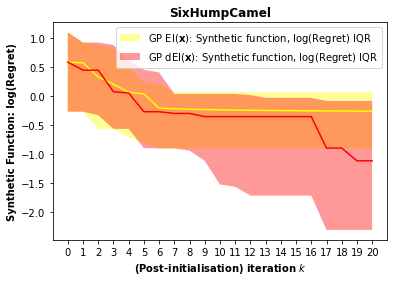

In [141]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


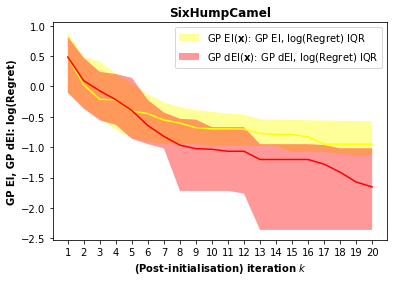

In [142]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx_acqFuncMin, color = 'Yellow')
plt.plot(median_exact_acqFuncMin, color = 'Red')

xstar = np.arange(0, max_iter, step=1)
plt.fill_between(xstar, lower_approx_acqFuncMin, upper_approx_acqFuncMin, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): GP EI, log(Regret) IQR')
plt.fill_between(xstar, lower_exact_acqFuncMin, upper_exact_acqFuncMin, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): GP dEI, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()
